# Final Project: Store Sales Forecasting

By (Tee) Thanh Nguyen

### Part 1: Introduction
The data employed in this analysis is sourced from the 'Store Sales - Time Series Forecasting' dataset from [Kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data).

In this notebook, we will undertake the task of predicting the future sales for products at the Favorita retail chain in Ecuador. The dataset which has been simplified to encompass a range of variables including specifics of the store and items, promotional activity indicators, and historical sales figures.

In [1]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pylab import rcParams

from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from prophet import Prophet

import joblib

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Set pandas options to display floats without scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

sns.set_theme()

### Part 2: Data Prepping & EDA

#### 1. Load the dataset

Data files used (simplified versions of the original dataset):
1) store_sales_raw
2) holidays_events.csv
4) stores.csv

In [2]:
# Load all data and save to a dataframe
store_sales_df = pd.read_csv(r'../data/store_sales_raw.csv')
holidays_df = pd.read_csv(r'../data/holidays_events.csv')
store_df = pd.read_csv(r'../data/stores.csv')

In [3]:
# Print information about the main dataframe called 'store_sales_df'
store_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [4]:
# Print information about holidays & events in a dataframe called 'holidays_df'
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [5]:
# Print information about the stores in a dataframe called 'store_df'
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


#### 2. Data Prepping - Converting into Datetime format for all dataframes

In [6]:
# Transform the 'date' columns in both 'store_sales_df' and 'holidays_df' dataframes into Datetime format
store_sales_df['date'] = pd.to_datetime(store_sales_df.date)
holidays_df['date'] = pd.to_datetime(holidays_df.date)

In [7]:
store_sales_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0
1,1,2013-01-01,1,BABY CARE,0.00000,0
2,2,2013-01-01,1,BEAUTY,0.00000,0
3,3,2013-01-01,1,BEVERAGES,0.00000,0
4,4,2013-01-01,1,BOOKS,0.00000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.13300,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.55300,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.72900,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00000,8


In [8]:
# The 'date' column of 'store_sales_df' is now in datetime
store_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [9]:
holidays_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [10]:
# The 'date' column of holidays_df is now in datetime
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


#### 3. EDA on 'holidays_df' and 'store_df'

- Plot the Holidays & Events calendar with the 'holidays_df' dataframe:

In [11]:
# We're using the 'holidays_df' dataframe
holidays_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


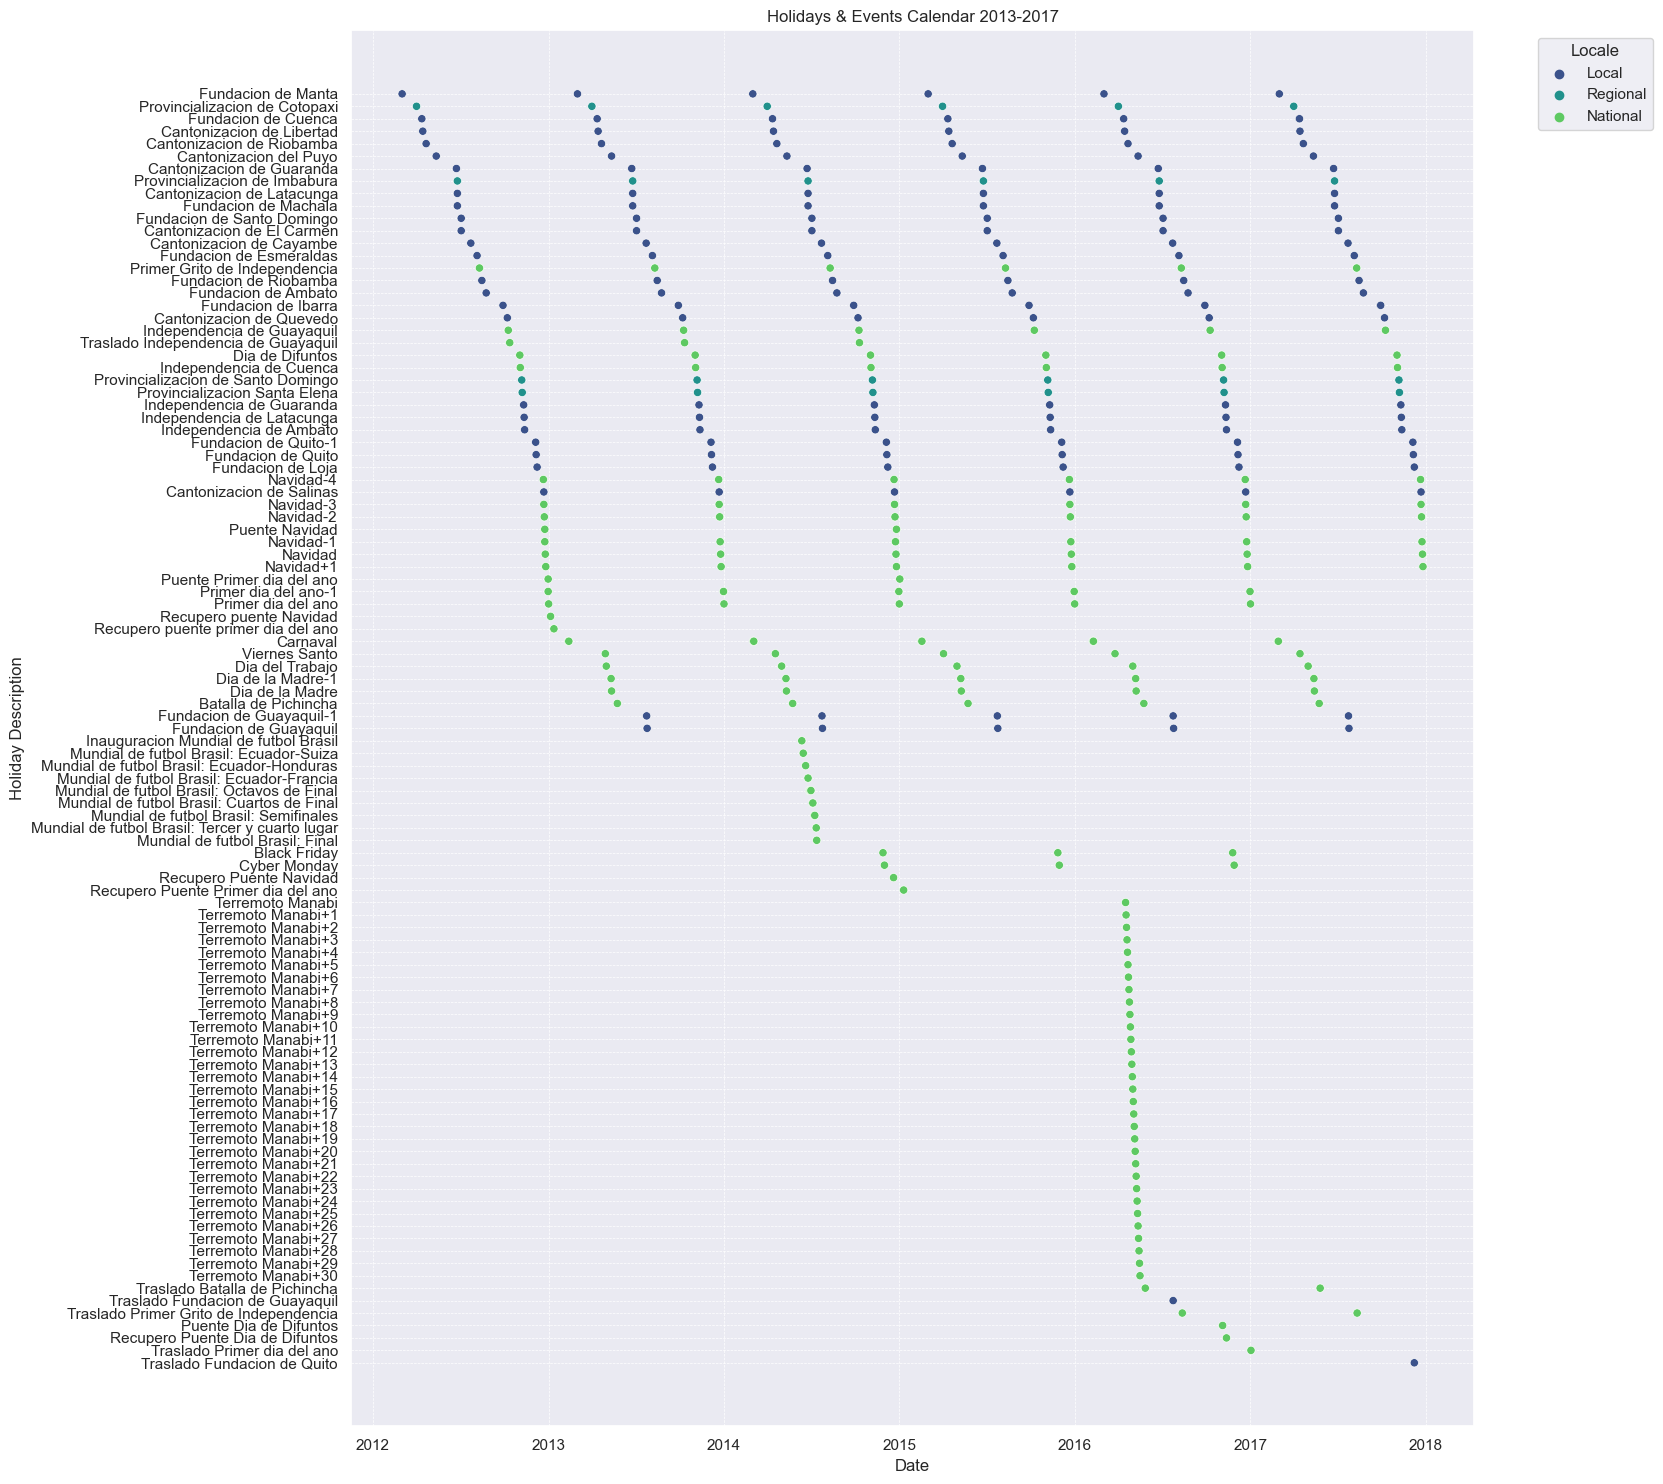

In [12]:
# Plot the 'holidays_df' dataframe into a Holidays & Events calendar
plt.figure(figsize=(15, 15))
sns.scatterplot(data=holidays_df, x='date', y='description', hue='locale', palette='viridis', marker='o')
plt.title('Holidays & Events Calendar 2013-2017')
plt.xlabel('Date')
plt.ylabel('Holiday Description')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(title='Locale', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

**Observations**:

* The plot categorizes holidays into three types, indicated by the color of the dots: local (blue), regional (green), and national (black). There is a mix of these types throughout the years.

* Certain holidays & events appear to occur annually, as indicated by the vertical clusters of dots that span across each year. These are likely fixed-date holidays in Ecuador such as New Year’s Day, Independence Day, or Christmas. 

* There are some events that occur only once, representing unique or one-off holidays/ events at the National level. For example, the 'Mundial de futbol Brasil' event clusters in 2014 refers to the celebration & support for the Ecuador national team participating in 2014 FIFA World Cup ([Source](https://es.wikipedia.org/wiki/Ecuador_en_la_Copa_Mundial_de_F%C3%BAtbol_de_2014)). Or the 2016 Ecuador earthquake resulting in the event series of "Terremoto Manabi" dated from 2016-04-16 to 2016-05-16. We'll discuss about the impact of the earthquake on sales later.

- Analyze and plot store-related insights from the 'store_df' dataframe:

In [13]:
# The number of unique stores
store_df.store_nbr.nunique()

54

In [14]:
# The number of unique states that stores are located in
store_df.state.nunique()

16

In [15]:
# The number of unique cities that stores are located in
store_df.city.nunique()

22

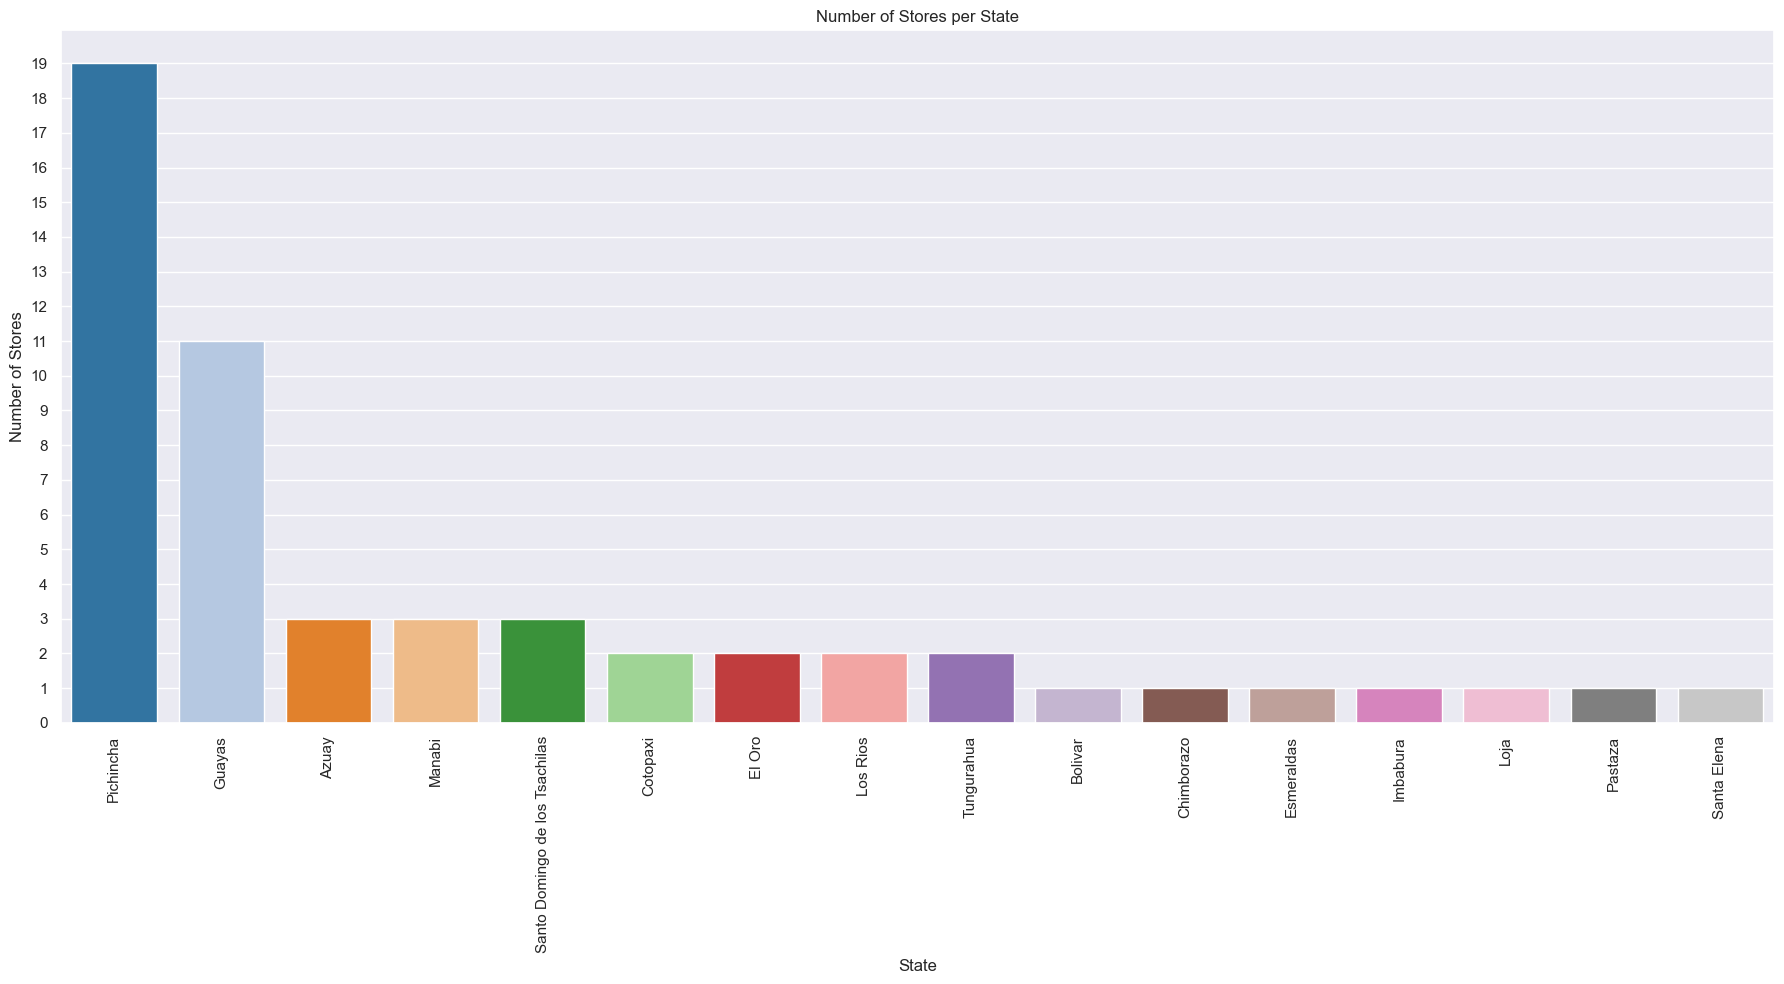

In [16]:
# Count the unique number of stores in each state
store_count = store_df.groupby('state').store_nbr.nunique().sort_values(ascending=False).reset_index()

# Plot the unique number of stores for each state in descending order
plt.figure(figsize=(18,10))
sns.barplot(data=store_count, x='state', y='store_nbr', palette='tab20')

# Setting whole number units for y-axis
max_stores = store_count['store_nbr'].max()
plt.yticks(list(range(0, max_stores + 1)))
plt.title('Number of Stores per State')
plt.ylabel('Number of Stores')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

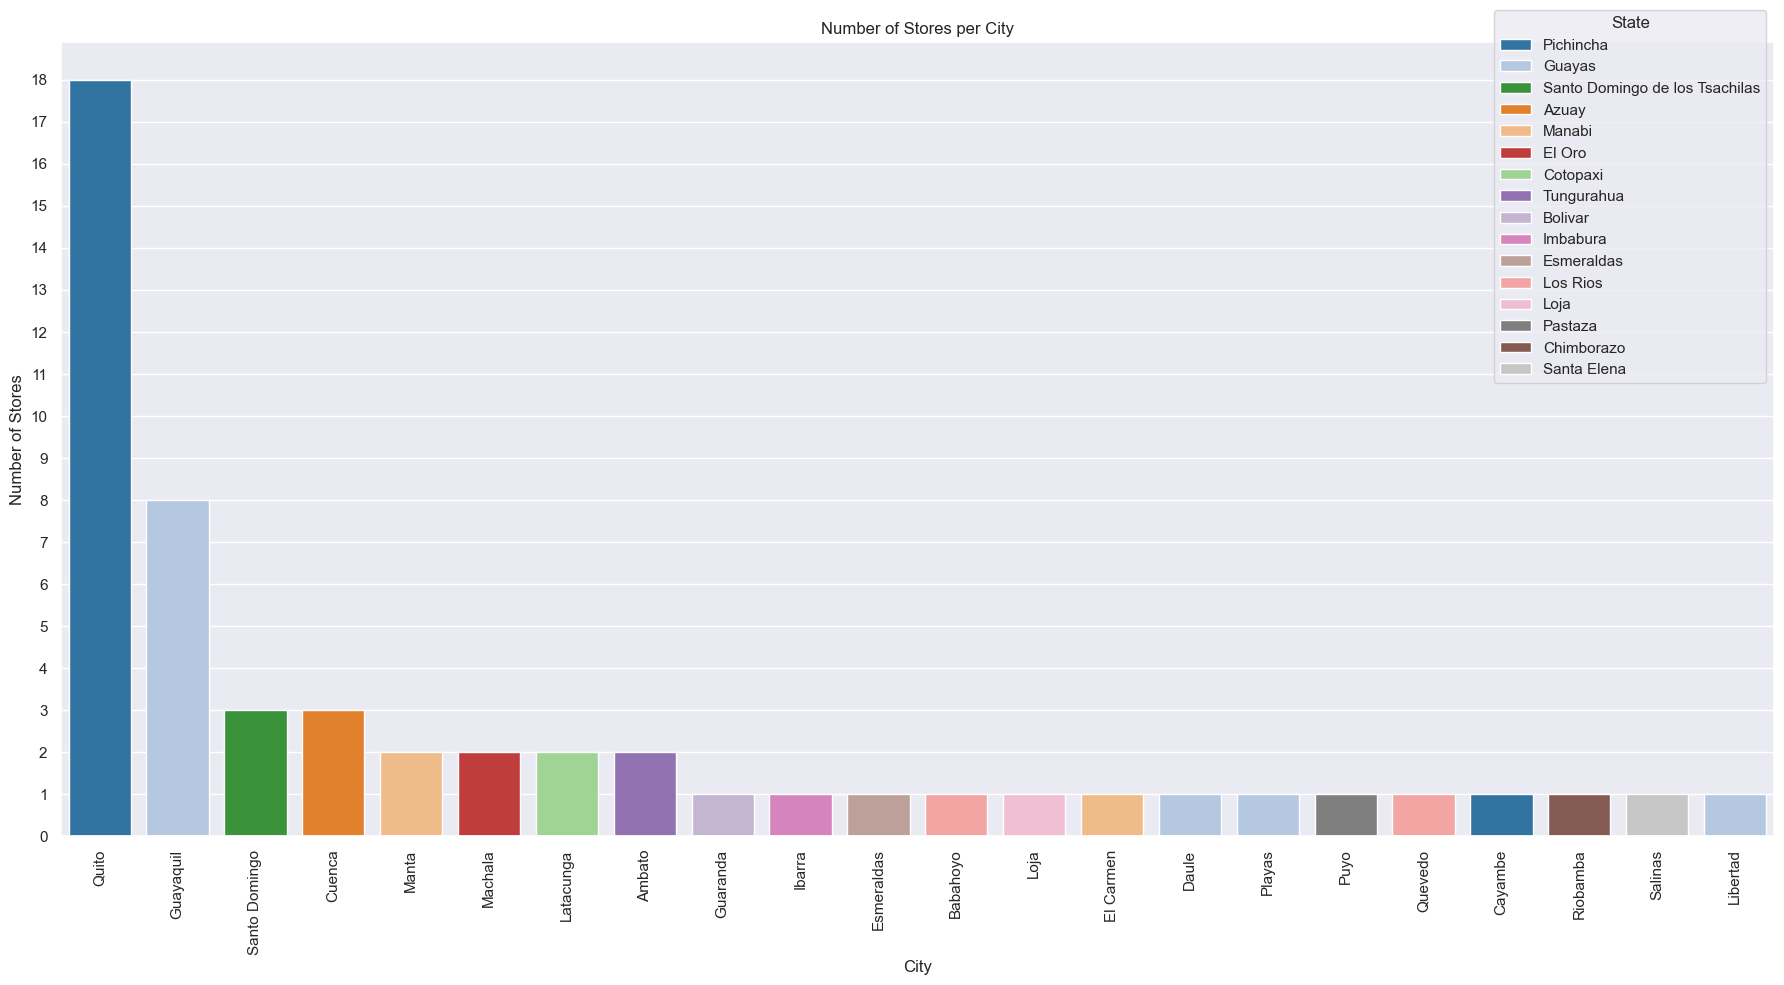

In [17]:
# Count the unique number of stores in each city with state as hue
store_count = store_df.groupby(['city', 'state']).store_nbr.nunique().sort_values(ascending=False).reset_index()

# Create a custom color palette to match with the state color map above
custom_palette = {
    'Pichincha': '#1f77b4',
    'Guayas': '#aec7e8',
    'Azuay': '#ff7f0e',
    'Manabi': '#ffbb78',
    'Santo Domingo de los Tsachilas': '#2ca02c',
    'Cotopaxi': '#98df8a',
    'El Oro': '#d62728',
    'Los Rios': '#ff9896',
    'Tungurahua': '#9467bd',
    'Bolivar': '#c5b0d5',
    'Chimborazo': '#8c564b',
    'Esmeraldas': '#c49c94',
    'Imbabura': '#e377c2',
    'Loja': '#f7b6d2',
    'Pastaza': '#7f7f7f',
    'Santa Elena': '#c7c7c7'
}

# Plot the unique number of stores for each city in descending order with hue as 'state'
plt.figure(figsize=(18,10))
sns.barplot(data=store_count, x='city', y='store_nbr', hue='state', palette=custom_palette, dodge=False, width=0.8)

# Setting whole number units for y-axis
max_stores = store_count['store_nbr'].max()
plt.yticks(list(range(0, max_stores + 1)))
plt.title('Number of Stores per City')
plt.ylabel('Number of Stores')
plt.xlabel('City')
plt.xticks(rotation=90)

# Move legend to the top right corner
plt.legend(title='State', loc='upper right', bbox_to_anchor=(1, 1.05))

plt.tight_layout()
plt.show()


#### 4. Data Prepping and EDA for the main dataframe 'store_sales_df'

- **Check null values and duplications in 'store_sales_df'**:

In [18]:
# No null values in 'store_sales_df'
store_sales_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [19]:
# No duplicated values in 'store_sales_df'
store_sales_df.duplicated().sum()

0

- **Add more date features to the 'store_sales_df' dataset:**

In [20]:
# Add more datetime columns to 'store_sales_df'
store_sales_df['year'] = store_sales_df['date'].dt.year
store_sales_df['month'] = store_sales_df['date'].dt.month
store_sales_df['week'] = store_sales_df['date'].dt.isocalendar().week.astype(int)
store_sales_df['day_name'] = store_sales_df['date'].dt.day_name()

In [21]:
store_sales_df

,id,date,store_nbr,family,sales,onpromotion,year,month,week,day_name
0,0,2013-01-01,1,AUTOMOTIVE,0.00000,0,2013,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.00000,0,2013,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.00000,0,2013,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.00000,0,2013,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.00000,0,2013,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.13300,0,2017,8,33,Tuesday
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.55300,1,2017,8,33,Tuesday
3000885,3000885,2017-08-15,9,PRODUCE,2419.72900,148,2017,8,33,Tuesday
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00000,8,2017,8,33,Tuesday


- **EDA for 'store_sales_df':**

Plot per sale for all sales data:

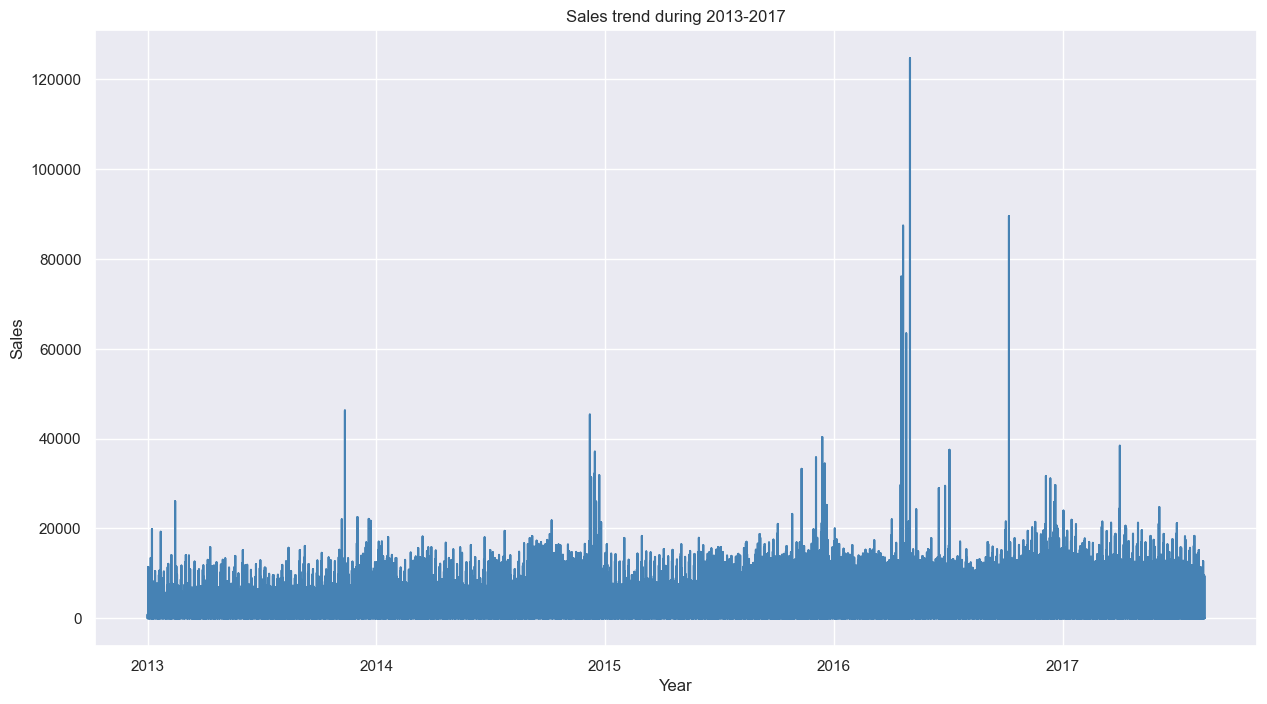

In [22]:
plt.figure(figsize=(15,8))
plt.plot(store_sales_df.date, store_sales_df.sales, color='steelblue')

# Setting the x-axis scale to be in year units
years = mdates.YearLocator()   # Every year
years_fmt = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.title('Sales trend during 2013-2017')
plt.ylabel('Sales')
plt.xlabel('Year')
plt.show()

Observations:
* The graph covers a time span from 2013 to 2017. Data from 2013-01-01 to 2017-08-15. 2017 data only covers until 15th of August (only half of the month).
* The data seems to display a relatively stable trend of sales with periodic spikes. The frequency of these spikes suggests some form of cyclical or seasonal trend. There are significant peaks in the end part of the year, from the 2013 - 2017 data.
* The year of 2016 have much more pronounced fluctuations of sales compared to other, which suggests a volatility during those years probably impacted by the external environment. The cause might be a magnitude 7.8 earthquake struck Ecuador on April 16, 2016. "People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake" ([Source](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)). If we compare the sales with the Holiday & Events calendar, there's an unprecedented national event windows called "Terremoto Manabi" that extended to "Terremoto Manabi +30" for 30 days.

Plot the sales trend by date using the total sales:

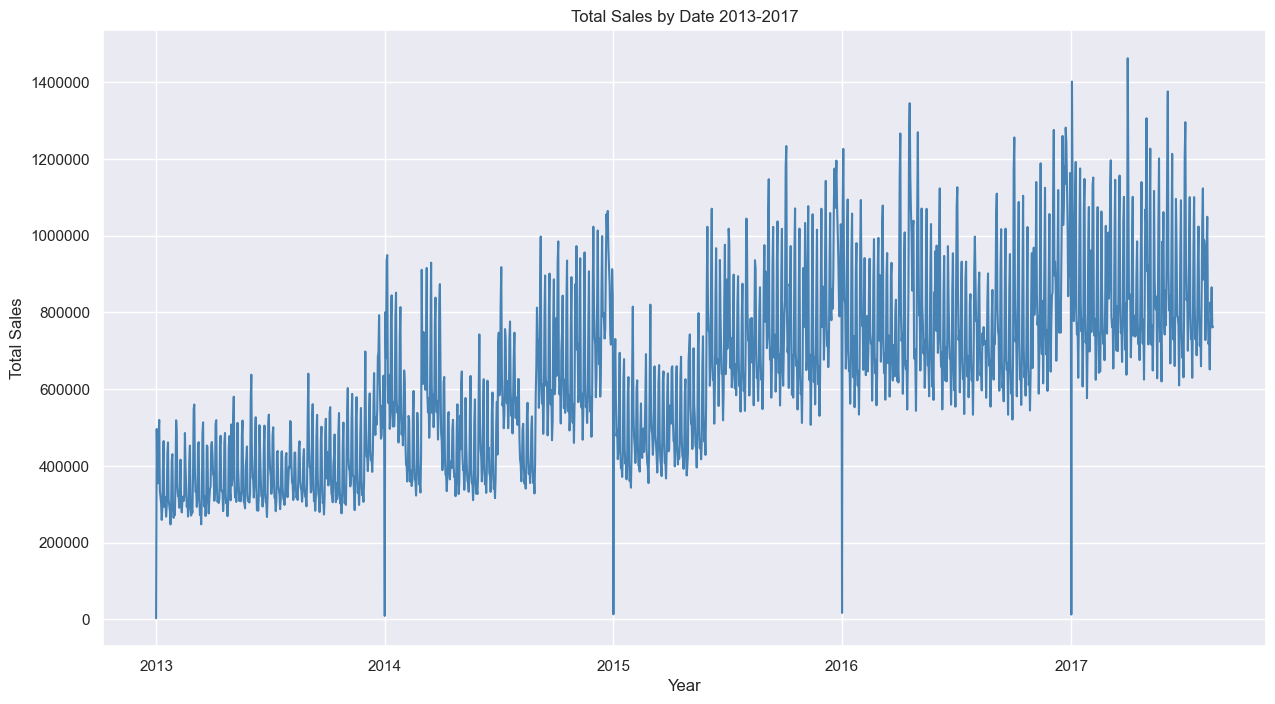

In [23]:
# Aggregate sales by date using sum
date_total_sales = store_sales_df.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(15,8))
plt.plot(date_total_sales.date, date_total_sales.sales, color='steelblue')
plt.ticklabel_format(style='plain', axis='y')
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.title('Total Sales by Date 2013-2017')
plt.ylabel('Total Sales')
plt.xlabel('Year')
plt.show()

Observations:

* The sales data exhibits periodic spikes, suggesting possible seasonal influences/events that results in peaks in sales. Starting from 2014 towards 2017, there is a noticeable increase in the frequency and height of the spikes. This could indicate growing customer interest, more successful marketing campaigns, or the expansion of the business.
* The sales figures from 2013 to 2017 show an overall upward trend.
* 2015: There's a noticeable change in the year 2015 where the sales figures seem to become denser with more frequent fluctuations.
* 2016: Towards the end of the chart, in 2017, there is a clear upward trend with sales figures consistently staying on the higher side. The impact of the Terremoto de Ecuador de 2016 earthquake might have impacted this trend starting from April 2016.

Plot the total sales by year to observe how much sales made in total over the years:

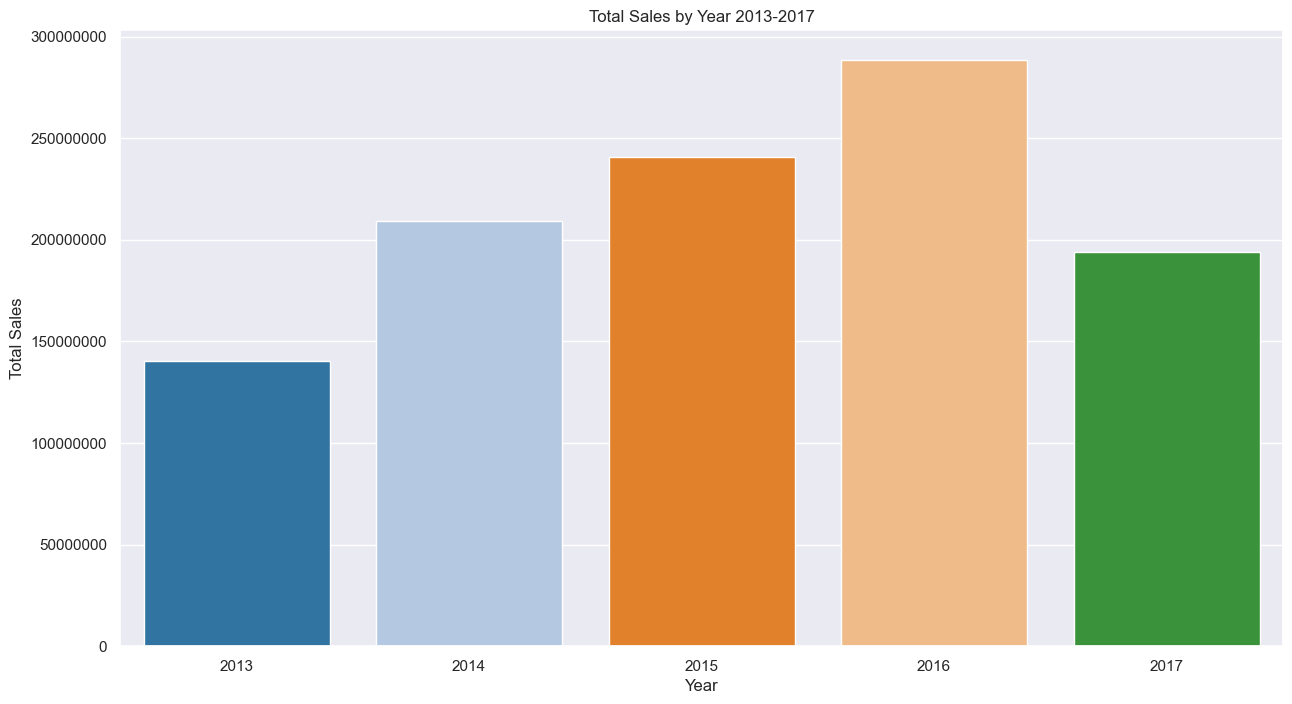

In [24]:
# Aggregate sales by year using the total sales
yearly_sales = store_sales_df.groupby('year')['sales'].sum().reset_index()

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=yearly_sales, x='year', y='sales', palette='tab20')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Total Sales by Year 2013-2017')
plt.ylabel('Total Sales')
plt.xlabel('Year')
plt.show()

Observations: There's a consistent growth in the total sales from 2013 to 2016. Each year experienced higher sales than the previous year.

Plot the average sales by month to observe the fluctuation of sales over the months:

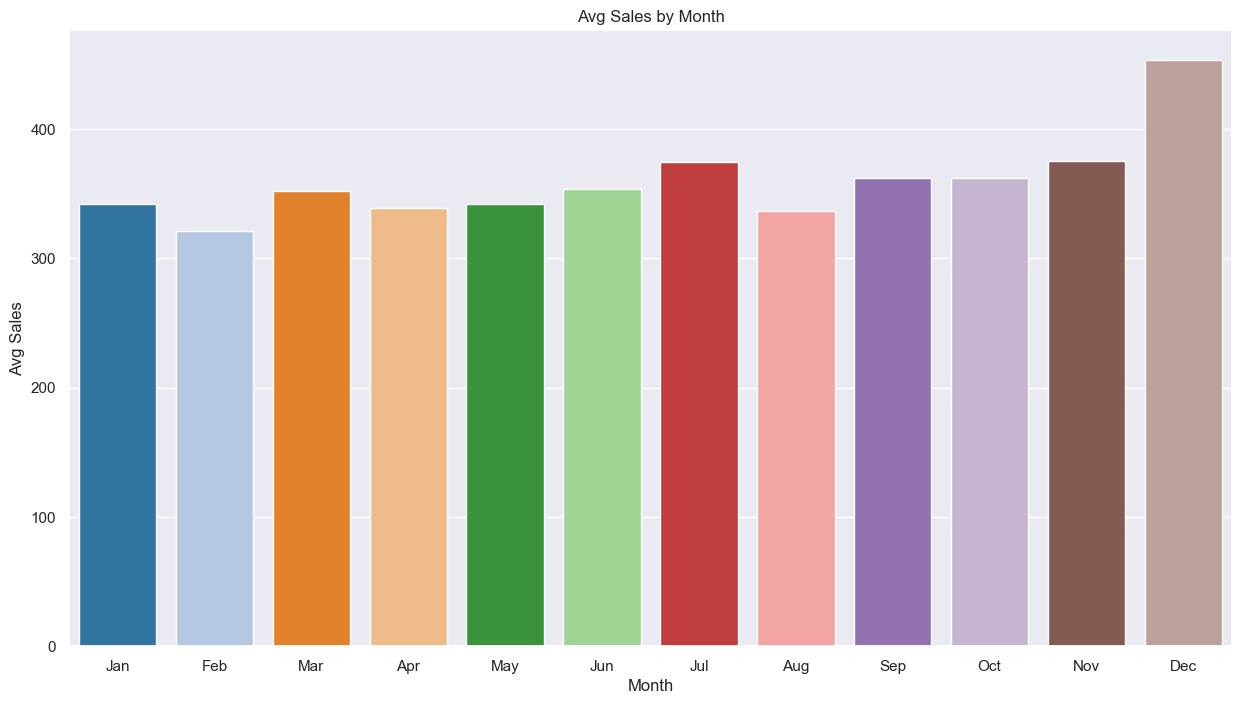

In [25]:
# Averge sales by month
monthly_sales = store_sales_df.groupby('month')['sales'].mean().reset_index()

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=monthly_sales, x='month', y='sales', palette='tab20')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Avg Sales by Month')
plt.ylabel('Avg Sales')
plt.xlabel('Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

Observations: The months with the lowest average sales are February and August. Sales then begin to rise again in the last quarter of the year, from September, October to December.

Plot the average sales by the day name to observe the fluctuations of sales over each day of the week:

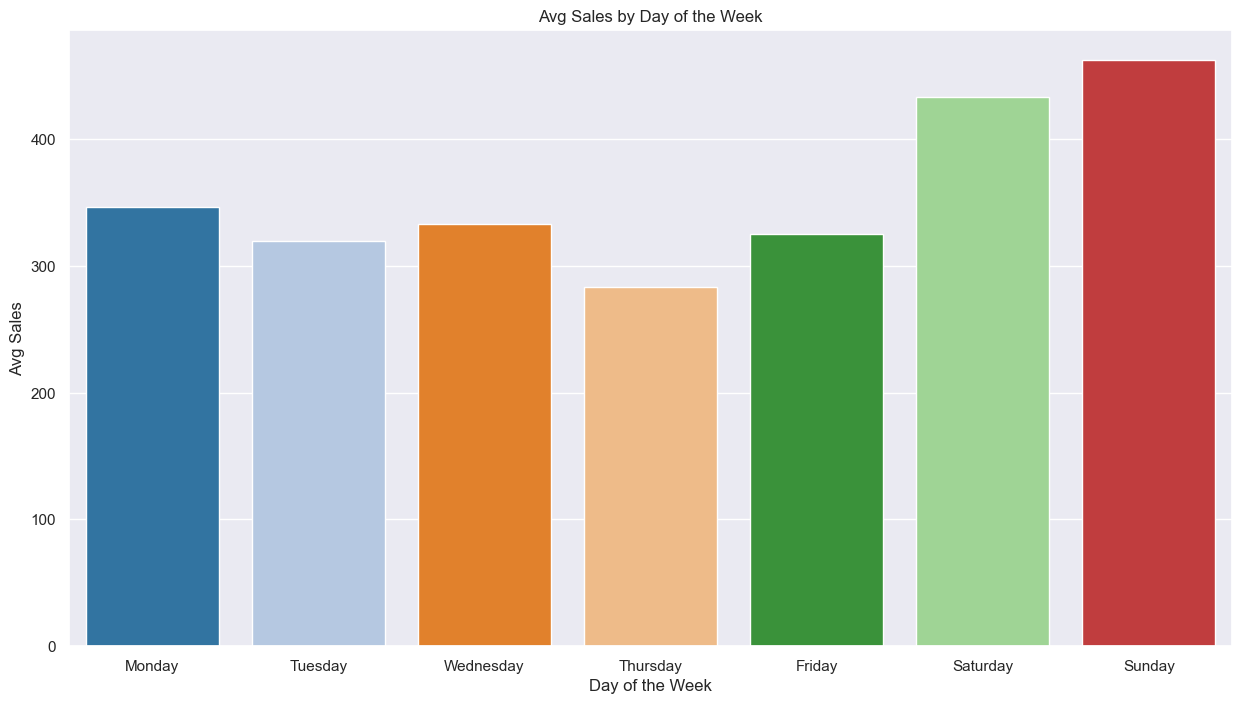

In [26]:
# Create a list of days in order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Average sales by day of the week
daily_sales = store_sales_df.groupby('day_name')['sales'].mean().reindex(days_order).reset_index()

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=daily_sales, x='day_name', y='sales', order=days_order, palette='tab20')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Avg Sales by Day of the Week')
plt.ylabel('Avg Sales')
plt.xlabel('Day of the Week')
plt.show()

Observations: There's a noticeable trend in the average sales throughout the week. Sales start relatively low on Monday through Wednesday, see a dip on Thursday, and starting to pick up from Friday through Sunday. Weekends such as Saturday and Sunday are the most popular grocery shopping days.

Plot the average sales by 'family' to observe the structure of sales per product family:

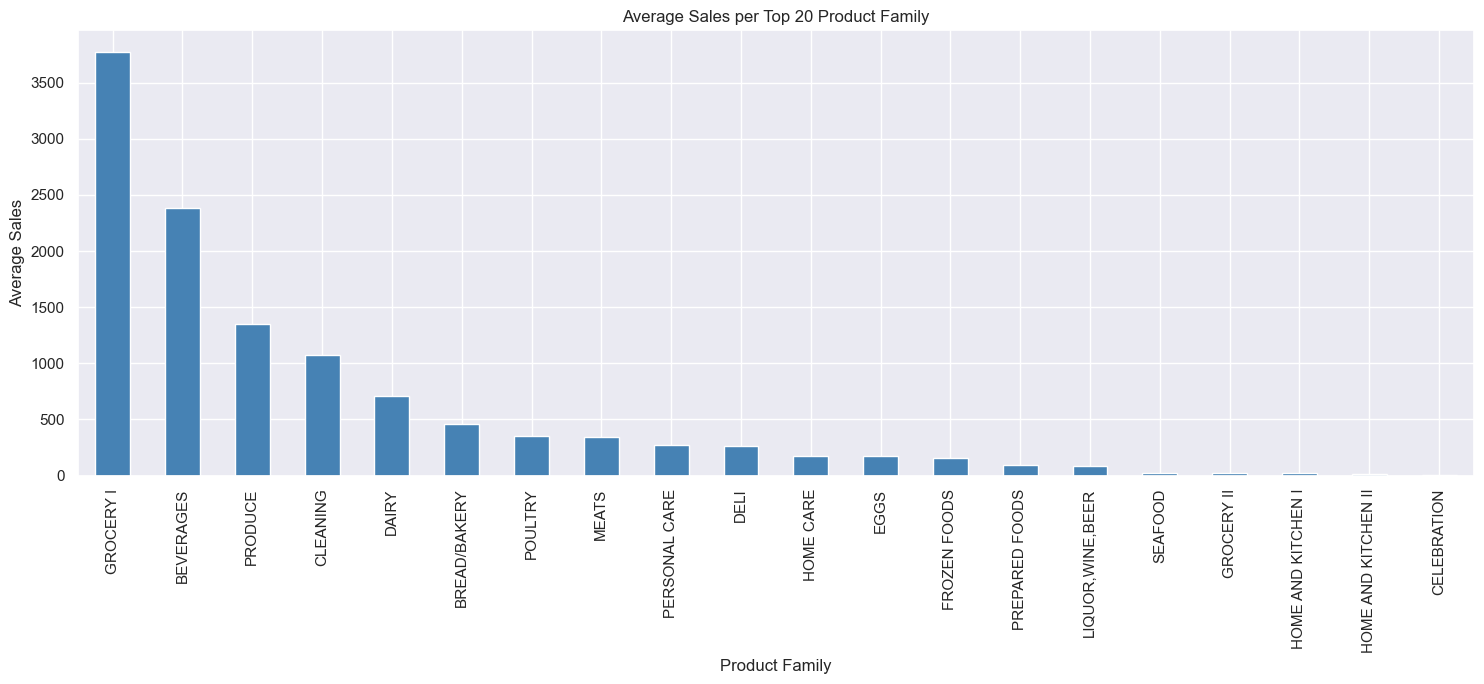

In [27]:
# Group by product 'family' and calculate the average sales
avg_sales = store_sales_df.groupby('family')['sales'].mean().sort_values(ascending=False)

# Take the top 20 product families
top_20_families = avg_sales.head(20)

# Plot
plt.figure(figsize=(15, 7))
top_20_families.plot(kind='bar', color='steelblue')
plt.title('Average Sales per Top 20 Product Family')
plt.ylabel('Average Sales')
plt.xlabel('Product Family')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Observations:

* The 'GROCERY I' product family has the highest average sales by a significant margin, second by 'BEVERAGES' which combined exceeding all other product families by a big distance. . The top 5 product families by average sales are 'GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', and 'DAIRY'.
* 'BREAD/BAKERY', 'POULTRY', 'MEATS', 'PERSONAL CARE', 'DELI', 'EGGS', 'FROZEN FOODS', 'HOME CARE', 'PREPARED FOODS', 'LIQUOR,WINE,BEER' belong to the low to moderate group of product family sales. There's a noticeable drop for the rest of the product families after the top 15.
* The top 20 product families cover a broad range of consumer goods, from grocery ('GROCERY I', 'GROCERY II'), essential food item (like 'DAIRY', 'POULTRY', 'EGGS'), beverages, meat, produce & frozen food, cleaning, health & beauty care to more niche categories ('CELEBRATION', 'HOME AND KITCHEN').

Plot and compare the yearly average promotion vs sales to observe any connected pattern:

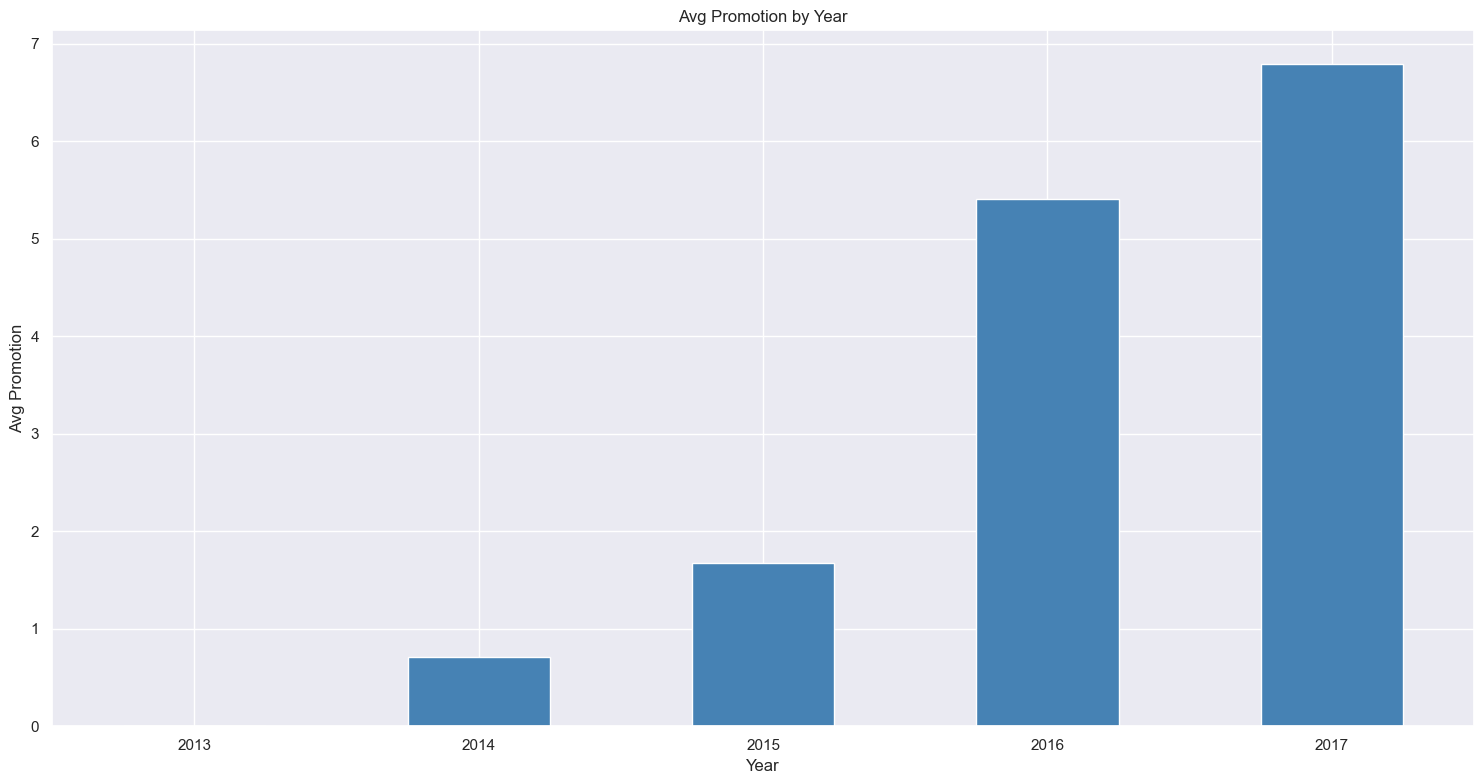

In [28]:
# Group by 'year' and average the 'onpromotion' column
yearly_promotions = store_sales_df.groupby('year')['onpromotion'].mean()

# Plot
plt.figure(figsize=(15,8))
yearly_promotions.plot(kind='bar', color='steelblue')
plt.title('Avg Promotion by Year')
plt.xlabel('Year')
plt.ylabel('Avg Promotion')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

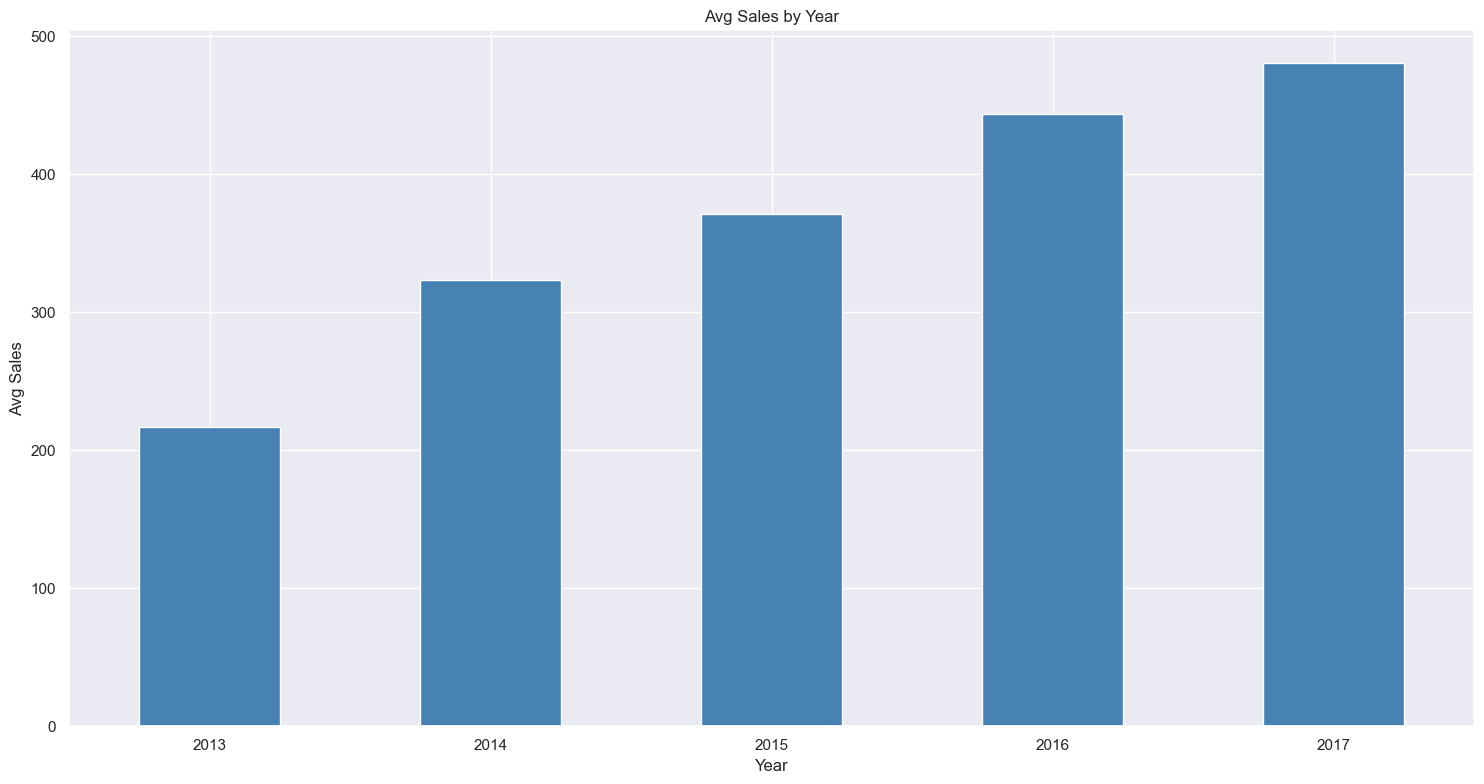

In [29]:
# Group by 'year' and average the 'sales' column
yearly_sales = store_sales_df.groupby('year')['sales'].mean()

# Plot
plt.figure(figsize=(15,8))
yearly_sales.plot(kind='bar', color='steelblue')
plt.title('Avg Sales by Year')
plt.xlabel('Year')
plt.ylabel('Avg Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Compare the Avg. Promotion vs. Avg. Sales per year:

* In terms of promotions trend: 2013 saw a minimal average promotion, almost close to zero, while there's a slight increase in promotions in 2014 but was still relatively low. The average number of promotions quickly increase from 2015 to 2016.
* In terms of sales trend: In 2013, the average sales were just above 200 almost without any promotion. The average sales increased by nearly one-third in 2014, approaching the 300 mark with around 1 promo on average per year. Although there are nearly 2 promotions on average per year in 2015, the year 2015 experienced a slower growth compared to 2014. The average number of promotions skyrocketed to almost 5 per year in 2016, whereas the highest average sales were also recorded in 2016, surpassing 400. 
* The rise in average sales from 2013 to 2014 might correspond to promotions, but can also indicates that other factors not captured in our charts.
* 2016 had both the highest promotions and sales, which overlaps with the earthquake event in 2016. The promotional strategy and external factors benefiting the business sales that year don't necessarily indicate positive impacts on profits. The grocery chain might receive funding from the government or investing more on CSR after the dreaded event. We'll investigate about that right after with the comparison between the average promotion and sales per month of each year.

Plot and compare the monthly average promotion vs sales to observe any connected pattern:

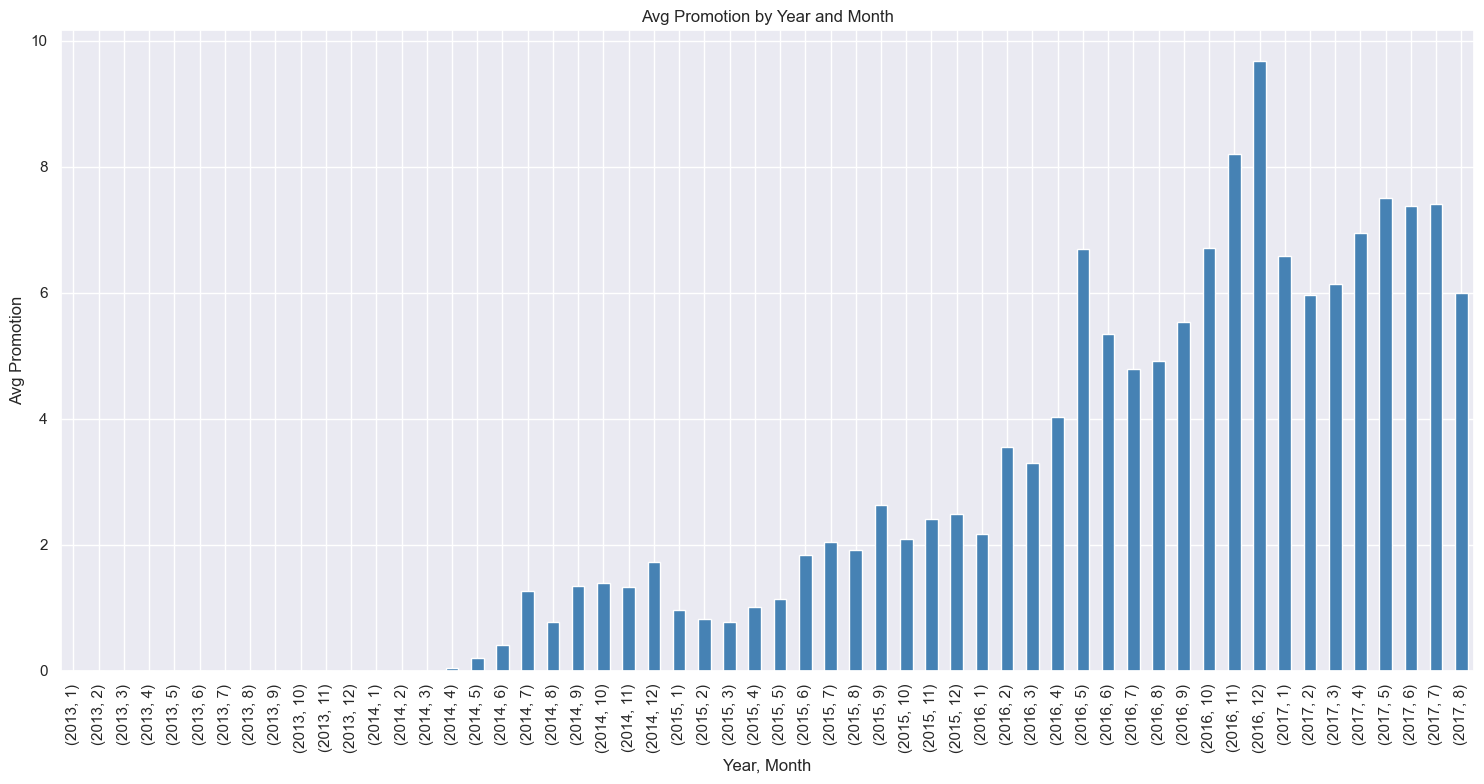

In [30]:
# Group by 'year' and 'month' and then compute the mean of the 'onpromotion' column
year_month_promotions = store_sales_df.groupby(['year', 'month'])['onpromotion'].mean()

# Plot
plt.figure(figsize=(15,8))
year_month_promotions.plot(kind='bar', color='steelblue')
plt.title('Avg Promotion by Year and Month')
plt.xlabel('Year, Month')
plt.ylabel('Avg Promotion')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

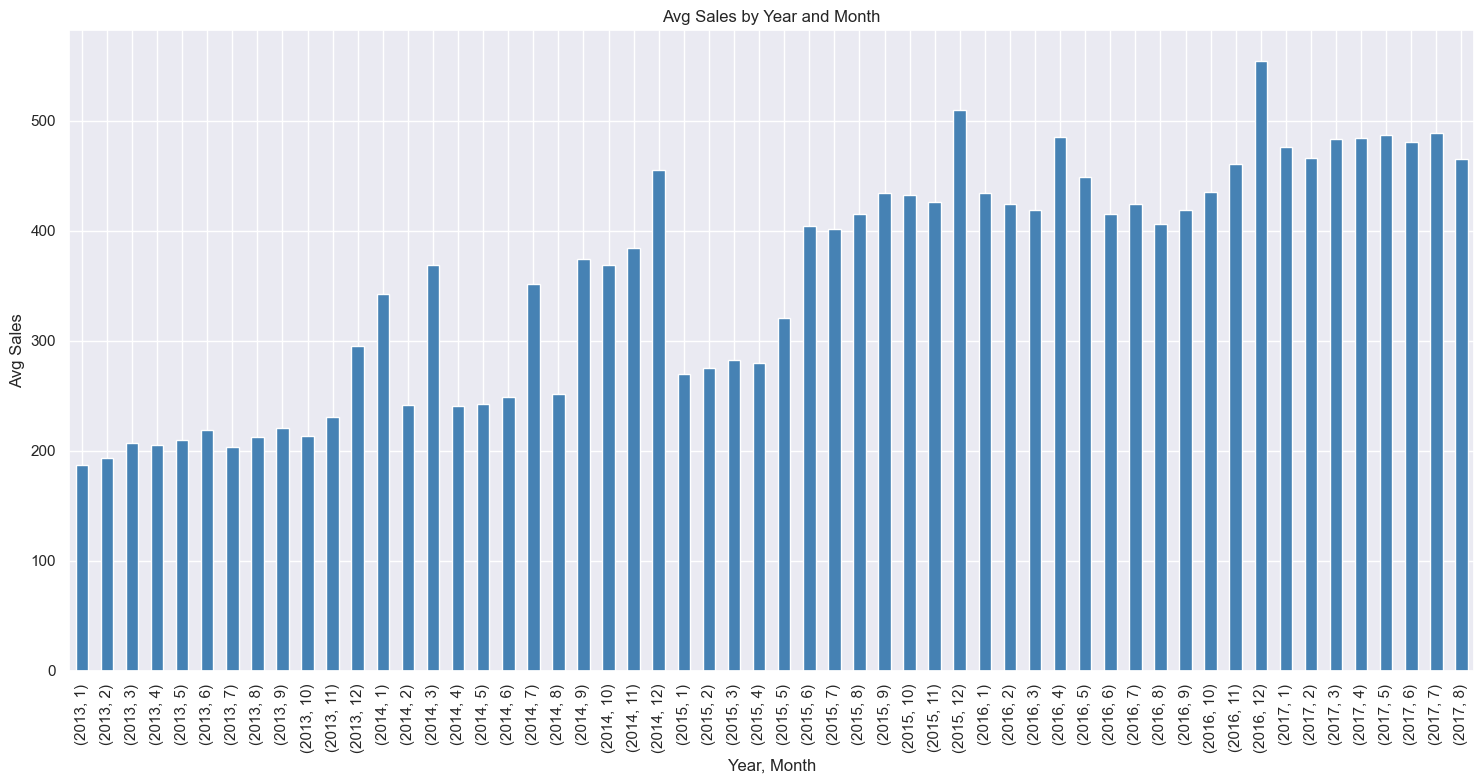

In [31]:
# Group by 'year' and 'month' and then compute the mean of the 'sales' column
year_month_sales = store_sales_df.groupby(['year', 'month'])['sales'].mean()

# Plotting
plt.figure(figsize=(15,8))
year_month_sales.plot(kind='bar', color='steelblue')
plt.title('Avg Sales by Year and Month')
plt.xlabel('Year, Month')
plt.ylabel('Avg Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Compare Avg. Promotion vs. Avg. Sales per month of the year:

* Avg Promotion by Year and Month: The average promotion remained relatively low from the beginning of 2013 up to mid-2015. Starting from late 2015, there's a noticeable upward trend in the average promotion, with the values increasing steadily. There is a clear trend of the business focusing on upping the average number of promotions from September to December every year. It's the period where the demand for buying grocery increase vastly with Christmas and New Year, which could also be attributed to holiday promotions or year-end sales drives.
* Avg Sales by Year and Month: There seems to have a connection between promotions and sales, especially in 2014 and 2016. There's no clear trend in 2015, with some peaks and troughs but not much linked to promotion. That could come from other external factors.

#### 4. Decompose the series to see the trend, seasonal, and residual components

In [32]:
# Copy the 'date_total_sales' object created above to 'date_total_sales2'
date_total_sales2 = date_total_sales.copy()

# Aggregate the Time Series to a monthly scaled index
date_total_sales2.set_index('date', inplace=True)
date_total_sales2

,sales
date,
2013-01-01,2511.61900
2013-01-02,496092.41794
2013-01-03,361461.23112
2013-01-04,354459.67709
2013-01-05,477350.12123
...,...
2017-08-11,826373.72202
2017-08-12,792630.53508
2017-08-13,865639.67747


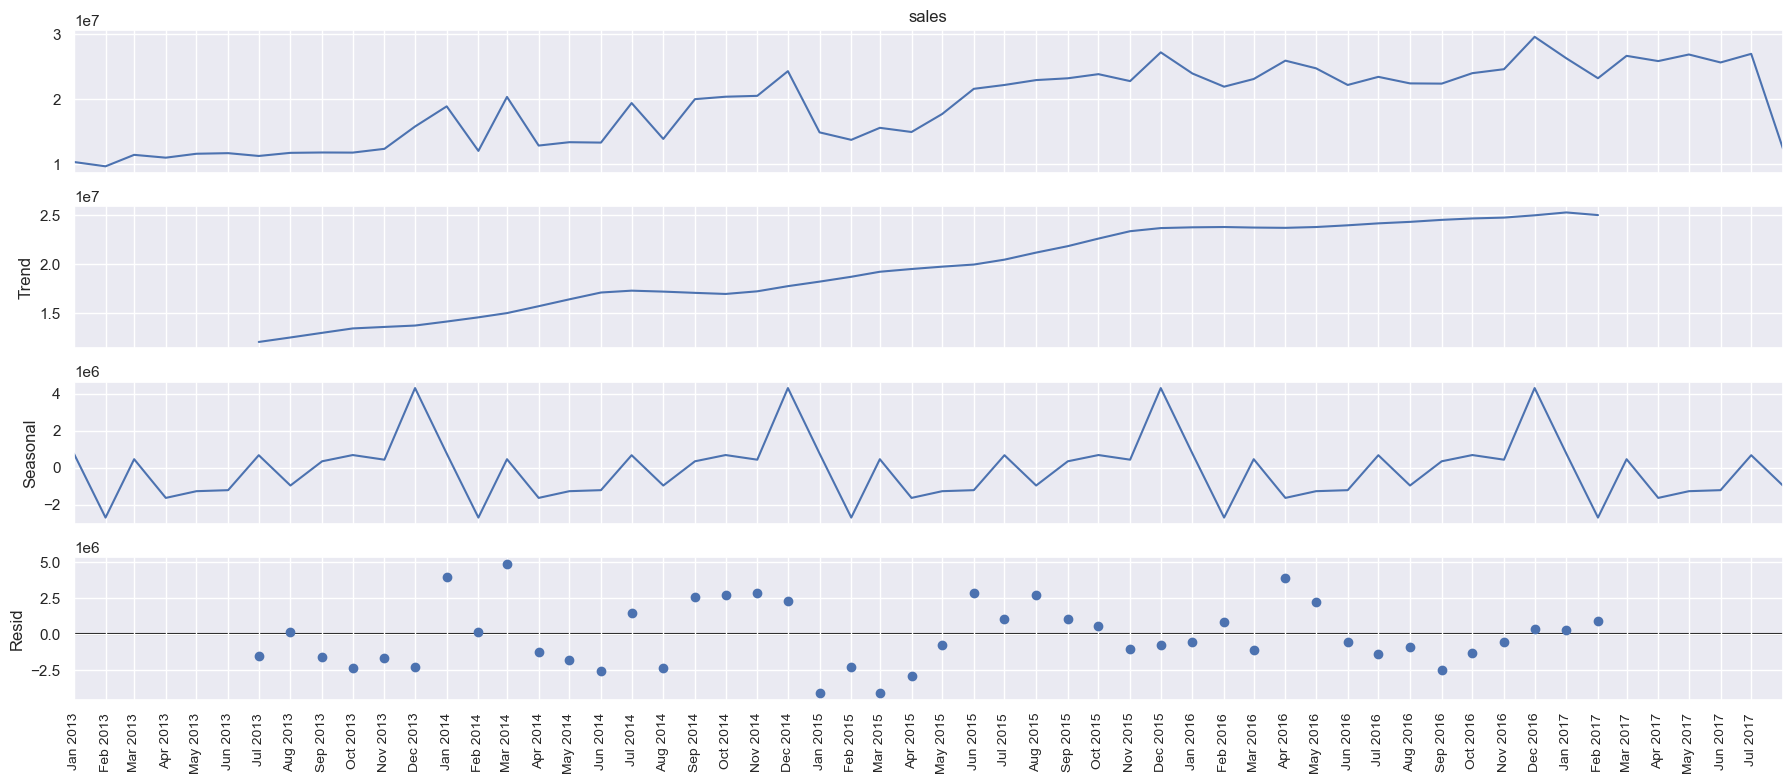

In [33]:
# Check for trends and seasonal patterns visually by the decomposition plot - by monthly

# Resample the time series data, compute the sum of sales for each month grouped by the start of each month
y = date_total_sales2['sales'].resample('MS').sum()

# Set the figure size
rcParams['figure.figsize'] = 18, 8

# Decompose the time series
decomposition = seasonal_decompose(y, model='additive')

# Plot the decomposition
fig = decomposition.plot()

# Generate a list of all months from 2013 to end of July 2017
all_months = pd.date_range(start='2013-01-01', end='2017-07-31', freq='MS')

# Set these dates as x-ticks and format the x-tick labels to show month and year
plt.xticks(all_months, all_months.strftime('%b %Y'), rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

Observations: There's an increasing trend in sales from 2013 to 2017. Clear annual seasonality exists, with certain months consistently showing higher or lower sales. Some unusual residuals are observed which might need further investigation to identify possible anomalies or events influencing sales in those months.

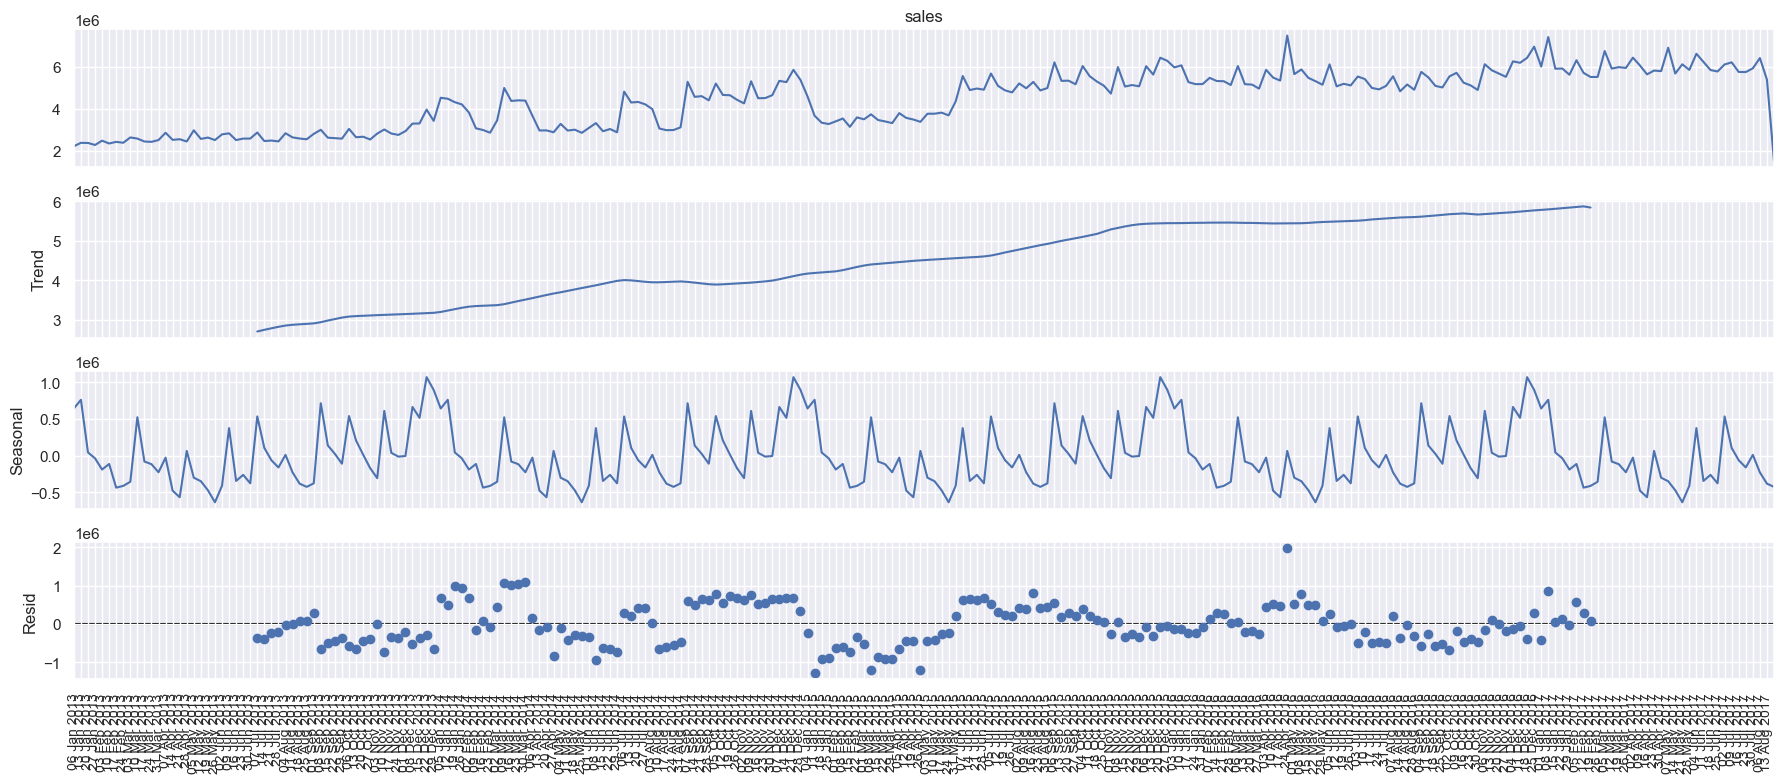

In [34]:
# Check for trends and seasonal patterns visually by the decomposition plot - by weekly

# Resample the time series data, compute the sum of sales for each month grouped by the start of each month
y2 = date_total_sales2['sales'].resample('W').sum()

# Set the figure size
rcParams['figure.figsize'] = 18, 8

# Decompose the time series
decomposition = seasonal_decompose(y2, model='additive')

# Plot the decomposition
fig = decomposition.plot()

# Generate a list of all weeks from 2013 to mid of August 2017
all_weeks = pd.date_range(start='2013-01-01', end='2017-08-15', freq='W')

# Set these dates as x-ticks and format the x-tick labels to show month and year
plt.xticks(all_weeks, all_weeks.strftime('%d %b %Y'), rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

Observations: There's also an increasing trend in sales from 2013 to 2017. Clear annual seasonality exists, with certain weeks consistently showing higher or lower sales. Some unusual residuals are observed which might need further investigation to identify possible anomalies or events influencing sales in those weeks. We may start with the weekly seasonality.

#### 5. The augmented Dicky-Fuller test for stationarity

In [35]:
# Create a function for the augmented Dicky-Fuller test
def adf_test(series, title=''):
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4], index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
              

# Apply the 'adf_test' function to the weekly scaled resampled time series y2 above
adf_test(y2, title='')

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.91378
p-value                  0.32560
# lags used              9.00000
# observations         232.00000
critical value (1%)     -3.45885
critical value (5%)     -2.87408
critical value (10%)    -2.57345
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


#### 6. Autocorrelation plots (ACF), partial autocorrelation plots (PACF) and Weekly Differencing

Autocorrelation assesses the relationship between a time series and a delayed version of itself. Autocorrelation plots (ACF) and partial autocorrelation plots (PACF) are useful tools for detecting important lags and discerning whether autoregressive or moving average elements are present in the time series.

In [36]:
# Calculate the autocorrelation value
autocorr = date_total_sales2['sales'].autocorr()
print("Autocorrelation:", autocorr)

Autocorrelation: 0.7668836879523088


Because the autocorrelation value is close to 1, there is a positive autocorrelation which indicates a relationship between the current sales values and the previous sales values.

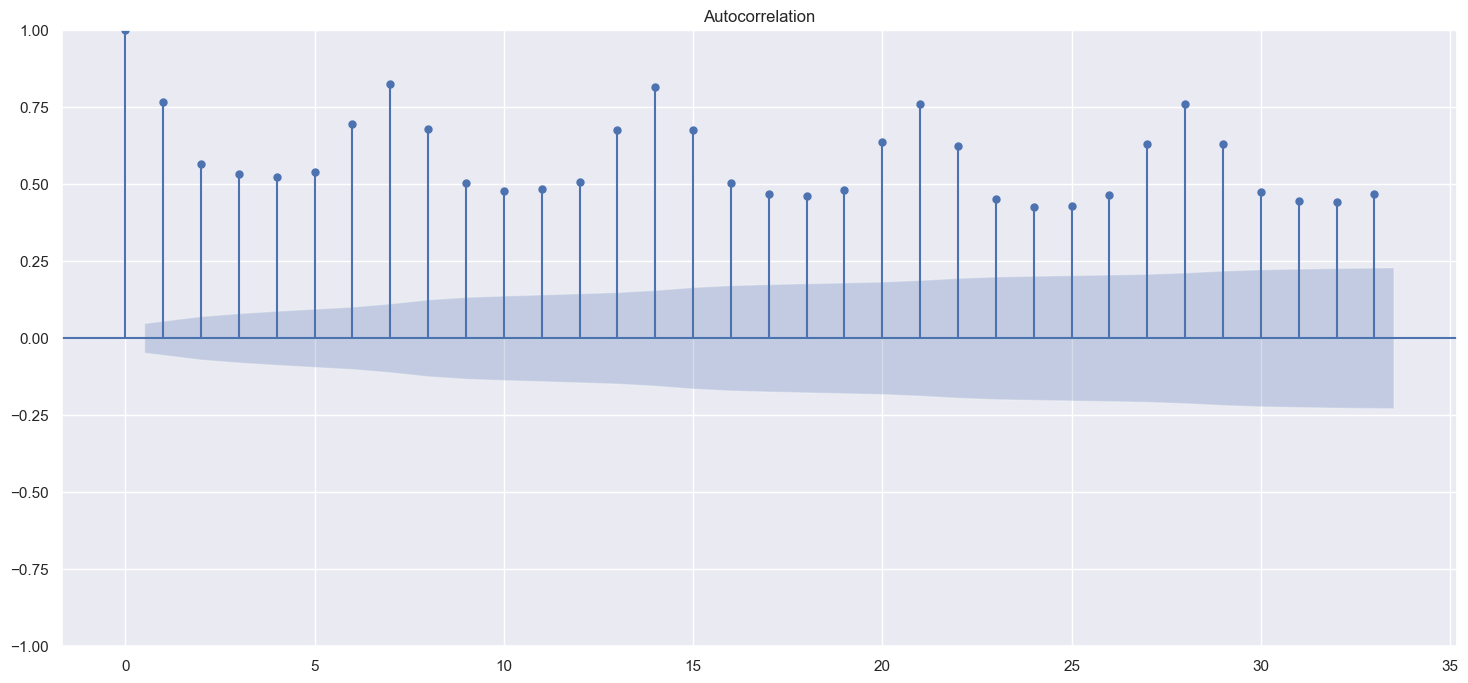

In [37]:
# Plot the ACF plot
plot_acf(date_total_sales2['sales'])
plt.show()

The ACF plot has high values at every 6, 7 and 8 lags, it might indicate weekly seasonal components.

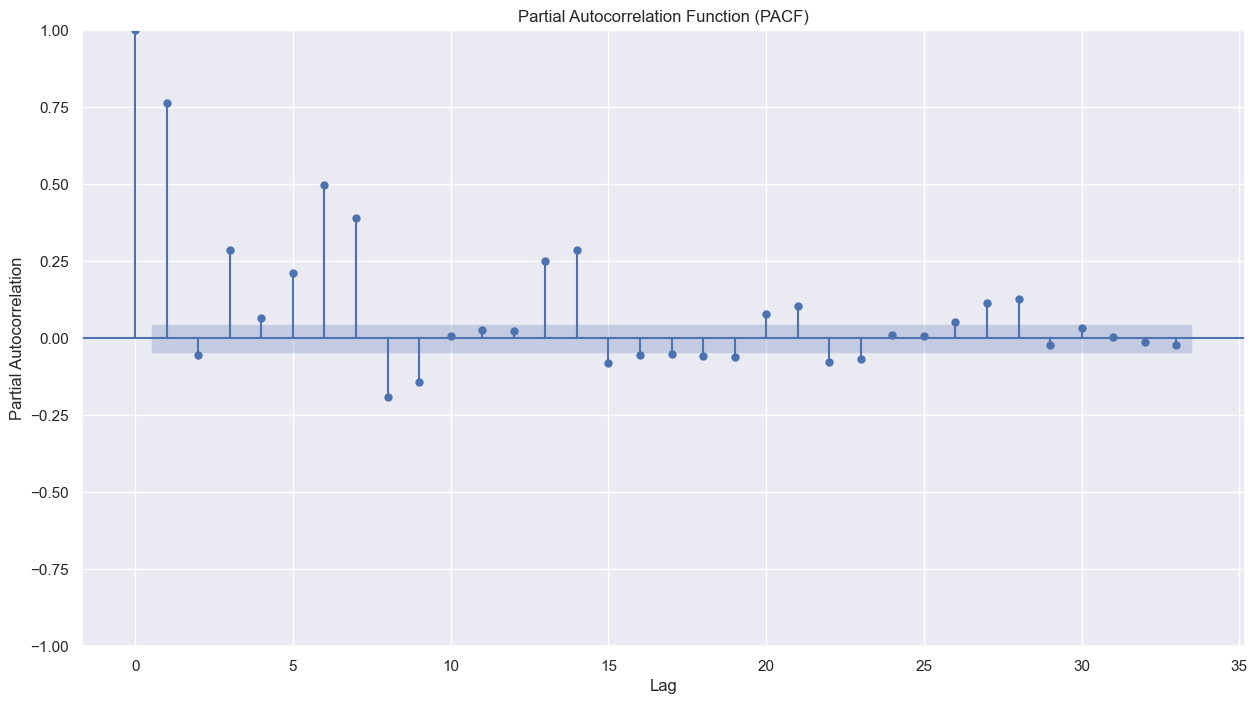

In [38]:
# Plot the PACF
fig, ax = plt.subplots(figsize=(15, 8))
plot_pacf(date_total_sales2['sales'], ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

In [39]:
# Create a copy of 'date_total_sales2' for weekly differencing
date_total_sales2_diff = date_total_sales2.copy()
date_total_sales2_diff

,sales
date,
2013-01-01,2511.61900
2013-01-02,496092.41794
2013-01-03,361461.23112
2013-01-04,354459.67709
2013-01-05,477350.12123
...,...
2017-08-11,826373.72202
2017-08-12,792630.53508
2017-08-13,865639.67747


In [41]:
# Calculate the 'sales_diff_weekly' by applying diff(7) to the ['sales'] column
date_total_sales2_diff['sales_diff_weekly'] = date_total_sales2_diff['sales'].diff(7)

# Drop na values
date_total_sales2_diff = date_total_sales2_diff.dropna()

# Check again 'date_total_sales2_diff'
date_total_sales2_diff

,sales,sales_diff_weekly
date,,
2013-01-15,299129.54995,-19218.22803
2013-01-16,318347.91395,15817.10493
2013-01-17,267498.51598,8516.51293
2013-01-18,296130.85003,6393.16494
2013-01-19,432459.85202,29201.64001
...,...,...
2017-08-11,826373.72202,-1401.96411
2017-08-12,792630.53508,-173063.11541
2017-08-13,865639.67747,-183919.48681


In [42]:
# Apply the 'adf_test' function to the 'sales_diff_weekly' differenced time series of date_total_sales2_diff
# Data is stationary now
adf_test(date_total_sales2_diff['sales_diff_weekly'], title='')

Augmented Dickey-Fuller Test: 
ADF test statistic      -12.04203
p-value                   0.00000
# lags used              22.00000
# observations         1647.00000
critical value (1%)      -3.43433
critical value (5%)      -2.86330
critical value (10%)     -2.56771
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


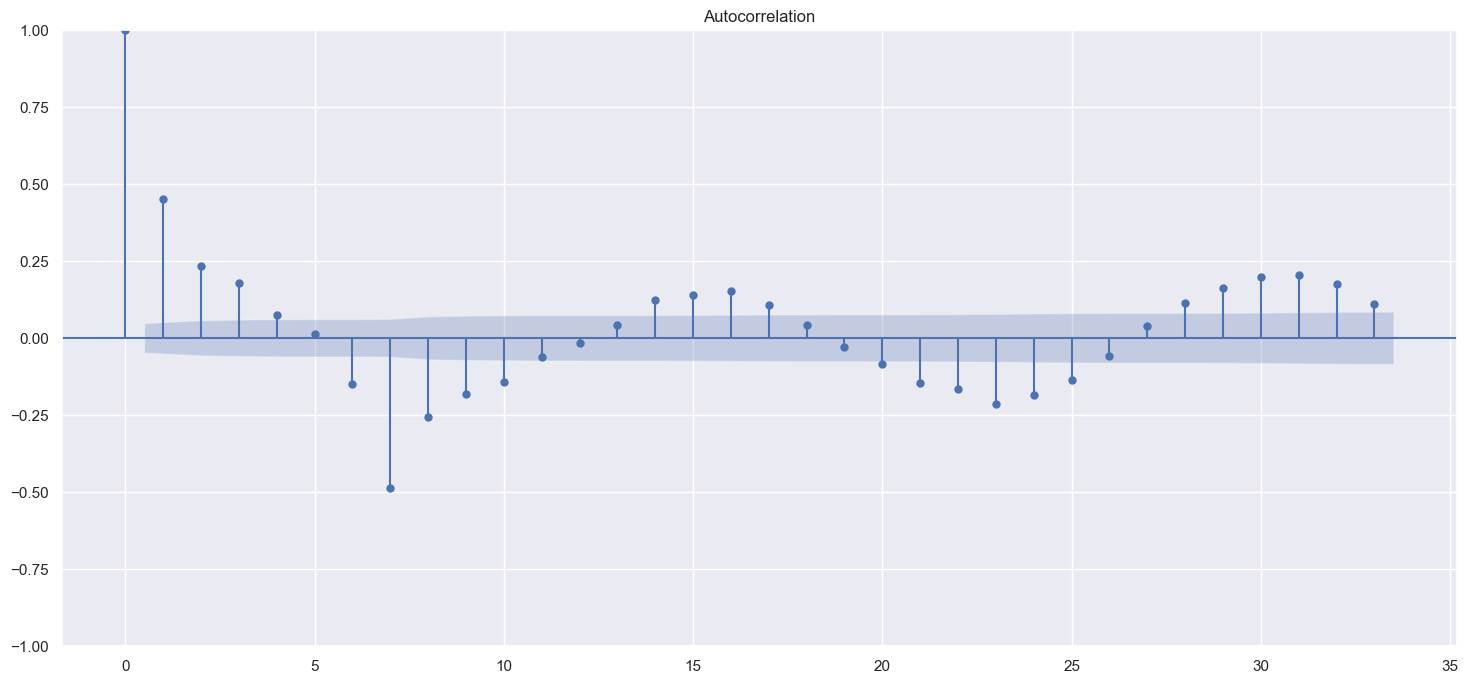

In [43]:
# Plot the ACF plot again with 'sales_diff_weekly'
plot_acf(date_total_sales2_diff['sales_diff_weekly'])
plt.show()

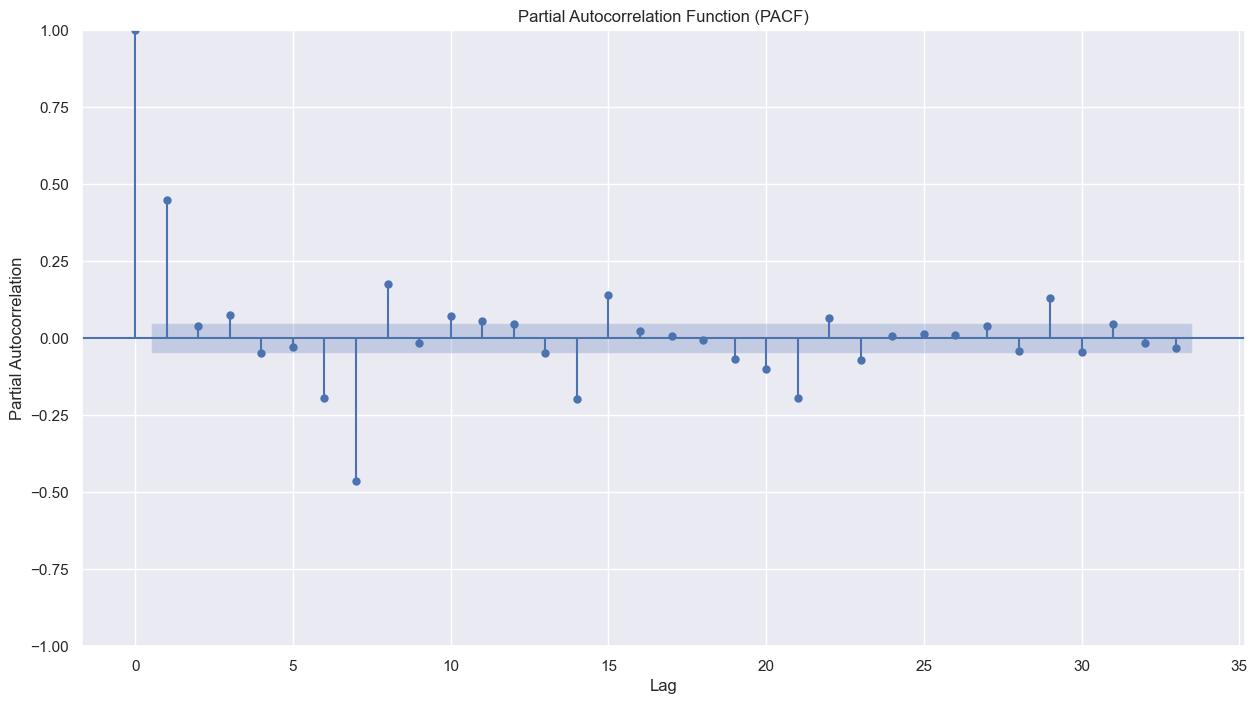

In [44]:
# Plot the PACF with 'sales_diff_weekly'
fig, ax = plt.subplots(figsize=(15, 8))
plot_pacf(date_total_sales2_diff['sales_diff_weekly'], ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

There is no more trend after remove weekly autocorrelation. As we have stationarity from the Augmented Dickey-Fuller Test after the first weekly differencing, we can assume D = 1, m = 7.

##### 7. Train-test split after confirming the data is stationary with D = 1, m = 7

In [45]:
# Train data - all data up to the end of 2016
train = date_total_sales2_diff.loc[:'2016']

# Test data - all data from 2017 onwards
test = date_total_sales2_diff.loc['2017':]

In [46]:
train

,sales,sales_diff_weekly
date,,
2013-01-15,299129.54995,-19218.22803
2013-01-16,318347.91395,15817.10493
2013-01-17,267498.51598,8516.51293
2013-01-18,296130.85003,6393.16494
2013-01-19,432459.85202,29201.64001
...,...,...
2016-12-27,842475.49012,-185767.33268
2016-12-28,951533.71385,-128868.67418
2016-12-29,894108.23683,-287199.09024


In [47]:
test

,sales,sales_diff_weekly
date,,
2017-01-01,12082.50100,-1234755.34206
2017-01-02,1402306.37083,369535.62194
2017-01-03,1104377.07982,261901.58971
2017-01-04,990093.46374,38559.74989
2017-01-05,777620.95407,-116487.28277
...,...,...
2017-08-11,826373.72202,-1401.96411
2017-08-12,792630.53508,-173063.11541
2017-08-13,865639.67747,-183919.48681


**Note:** We'll train the forecasting model on the 'train' data and use 'test' for validation of our forecast as we don't have a full year of data for 2017 (data only available until August 15, 2017). Also, sales forecasting usually take place at the end of the fiscal year and we're usually forecast for the whole year.

### Part 3: SARIMA and Facebook Prophet Models with Model-specific Prepping

##### 1. SARIMA Model

In [48]:
# Search over model orders by running auto_arima to find the best search parameters of ARIMA(p,d,q)
model = auto_arima(train['sales'], # Don't use the train['sales_diff_weekly'] here
                   start_p=2,
                   start_q=0,
                   max_p=3,
                   max_q=2,
                   m=7,
                   start_P=0, 
                   seasonal=True,
                   d=0,
                   D=1, # Already include the first differencing in D=1, m=7
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True
                   )

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=36906.547, Time=0.74 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=37897.890, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=37038.894, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=37102.078, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=37896.878, Time=0.09 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept   : AIC=37382.688, Time=0.29 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=36908.455, Time=1.34 sec
 ARIMA(2,0,0)(0,1,2)[7] intercept   : AIC=36908.460, Time=1.57 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=37037.167, Time=0.70 sec
 ARIMA(2,0,0)(1,1,2)[7] intercept   : AIC=36909.149, Time=3.07 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=36908.634, Time=0.64 sec
 ARIMA(3,0,0)(0,1,1)[7] intercept   : AIC=36890.219, Time=1.05 sec
 ARIMA(3,0,0)(0,1,0)[7] intercept   : AIC=37382.967, Time=0.40 sec
 ARIMA(3,0,0)(1,1,1)[7] intercept   : AIC=36892.219, Time=1.50 sec
 ARIMA(3,0,0)(0,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1443
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 7)   Log Likelihood              -18439.110
Date:                             Mon, 06 Nov 2023   AIC                          36890.219
Time:                                     20:36:57   BIC                          36921.837
Sample:                                          0   HQIC                         36902.023
                                            - 1443                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1379.6163    951.630      1.450      0.147    -485.545    3244.777
ar.L1          0.5743      0.016     36.611      0.000       0.544       0.605
ar.L2         -0.0167      0.030     -0.562      0.574      -0.075       0.042
ar.L3          0.1406      0.025      5.531      0.000       0.091       0.190
ma.S.L7       -0.7549      0.020    -37.864      0.000      -0.794      -0.716
sigma2      1.176e+10      0.000   7.11e+13      0.000    1.18e+10    1.18e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             16127.27
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.53e+29. Standard errors may be unstable.
"""

In [49]:
# Find the model orders from the auto_arima result
non_seasonal_order = model.order
seasonal_order = model.seasonal_order

print('non_seasonal_order:', non_seasonal_order)
print('seasonal order:', seasonal_order)

non_seasonal_order: (3, 0, 0)
seasonal order: (0, 1, 1, 7)


In [50]:
# Fit SARIMA based on the best auto_arima parameters result
sarima_model = SARIMAX(train['sales'],
                       order=non_seasonal_order,
                       seasonal_order=seasonal_order,
                       trend='c').fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                 1443
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 7)   Log Likelihood              -18439.110
Date:                             Mon, 06 Nov 2023   AIC                          36890.219
Time:                                     20:37:04   BIC                          36921.837
Sample:                                          0   HQIC                         36902.023
                                            - 1443                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1379.6163    951.630      1.450      0.147    -485.545    3244.777
ar.L1          0.5743      0.016     36.611      0.000       0.544       0.605
ar.L2         -0.0167      0.030     -0.562      0.574      -0.075       0.042
ar.L3          0.1406      0.025      5.531      0.000       0.091       0.190
ma.S.L7       -0.7549      0.020    -37.864      0.000      -0.794      -0.716
sigma2      1.176e+10      0.000   7.11e+13      0.000    1.18e+10    1.18e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             16127.27
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.53e+29. Standard errors may be unstable.
"""

In [51]:
# Select a filepath to save the SARIMA model
sarima_model_filepath = r'../models/sarima_model.joblib'

# Use joblib.dump to save the SARIMA model object to a file
joblib.dump(sarima_model, sarima_model_filepath)

['../models/sarima_model.joblib']

In [52]:
# Load the SARIMA model object from filepath
sarima_model_object = joblib.load(sarima_model_filepath)

In [53]:
# Forecast the next 227 days which is the length of the 'test' dataset
sarima_forecasts_result = sarima_model_object.get_forecast(steps=len(test))

# Extract the predicted mean values
sarima_forecasted_values = sarima_forecasts_result.predicted_mean

# Assign index from the test data for forecasted values
sarima_forecasted_values.index = test.index

# Create a DataFrame with the forecasted values
sarima_forecasted_values_df = pd.DataFrame({'sales_pred': sarima_forecasted_values})

# Check the resulting DataFrame
sarima_forecasted_values_df

,sales_pred
date,
2017-01-01,1153682.92625
2017-01-02,1246758.04132
2017-01-03,948943.39028
2017-01-04,932933.67988
2017-01-05,957450.99117
...,...
2017-08-11,1058292.77955
2017-08-12,1134514.75521
2017-08-13,1238676.15863


In [54]:
# Get the actual sales from the 'test' dataset
sarima_forecasted_values_df['sales_actual'] = test['sales']
sarima_forecasted_values_df

,sales_pred,sales_actual
date,,
2017-01-01,1153682.92625,12082.50100
2017-01-02,1246758.04132,1402306.37083
2017-01-03,948943.39028,1104377.07982
2017-01-04,932933.67988,990093.46374
2017-01-05,957450.99117,777620.95407
...,...,...
2017-08-11,1058292.77955,826373.72202
2017-08-12,1134514.75521,792630.53508
2017-08-13,1238676.15863,865639.67747


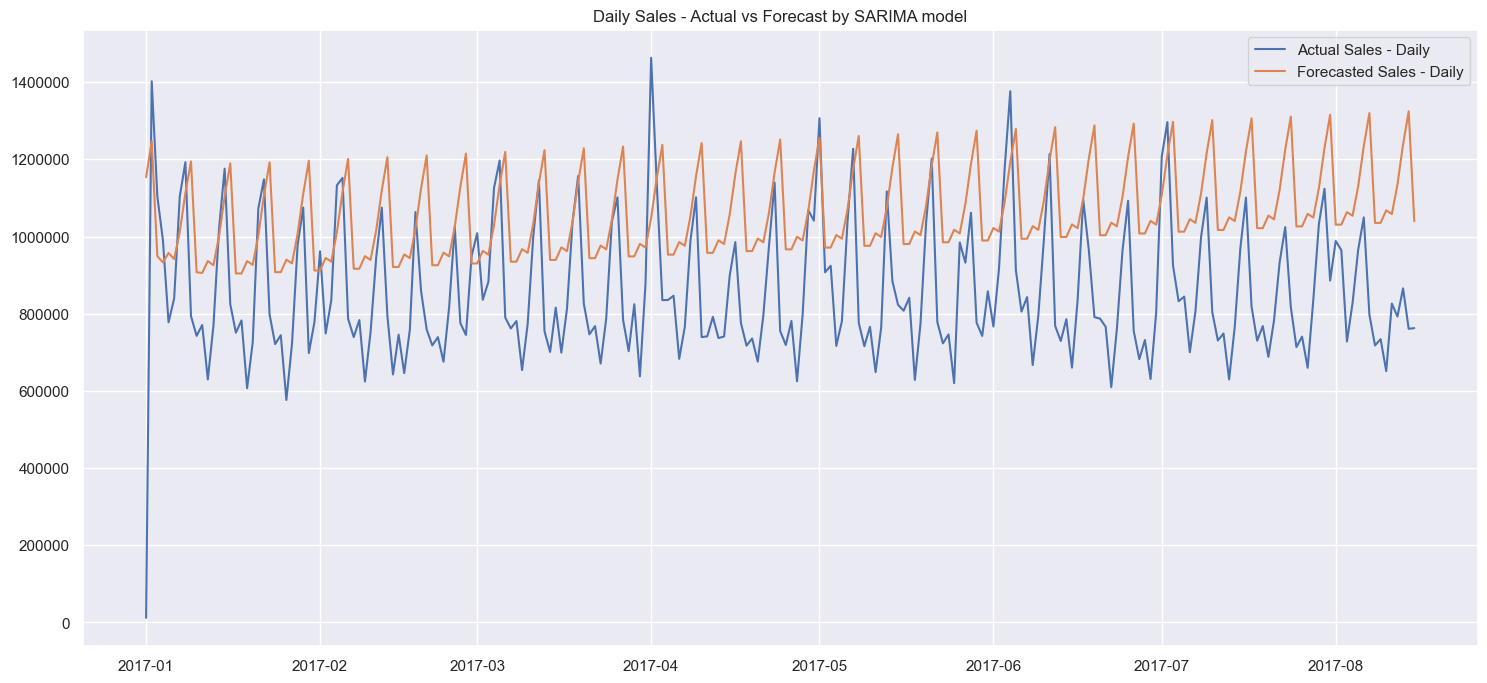

In [55]:
# Plot the daily actual sales and predicted values from the SARIMA model
plt.plot(sarima_forecasted_values_df['sales_actual'], label='Actual Sales - Daily')
plt.plot(sarima_forecasted_values_df['sales_pred'], label='Forecasted Sales - Daily')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.title('Daily Sales - Actual vs Forecast by SARIMA model')
plt.show()

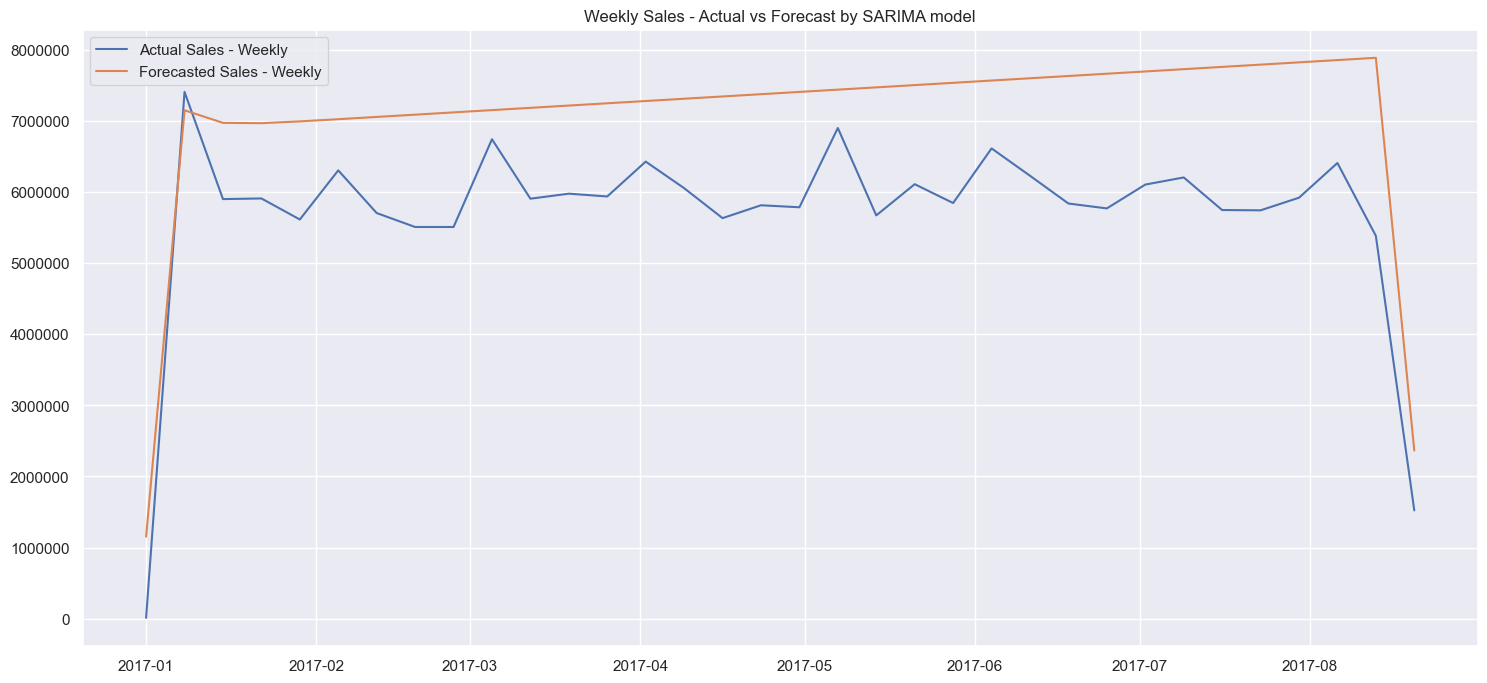

In [56]:
# Resample to weekly frequency, aggregating with sum
weekly_sales_sarima = sarima_forecasted_values_df.resample('W').sum()

# Plot the weekly actual sales and predicted values from the SARIMA model
plt.plot(weekly_sales_sarima['sales_actual'], label='Actual Sales - Weekly')
plt.plot(weekly_sales_sarima['sales_pred'], label='Forecasted Sales - Weekly')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.title('Weekly Sales - Actual vs Forecast by SARIMA model')
plt.show()

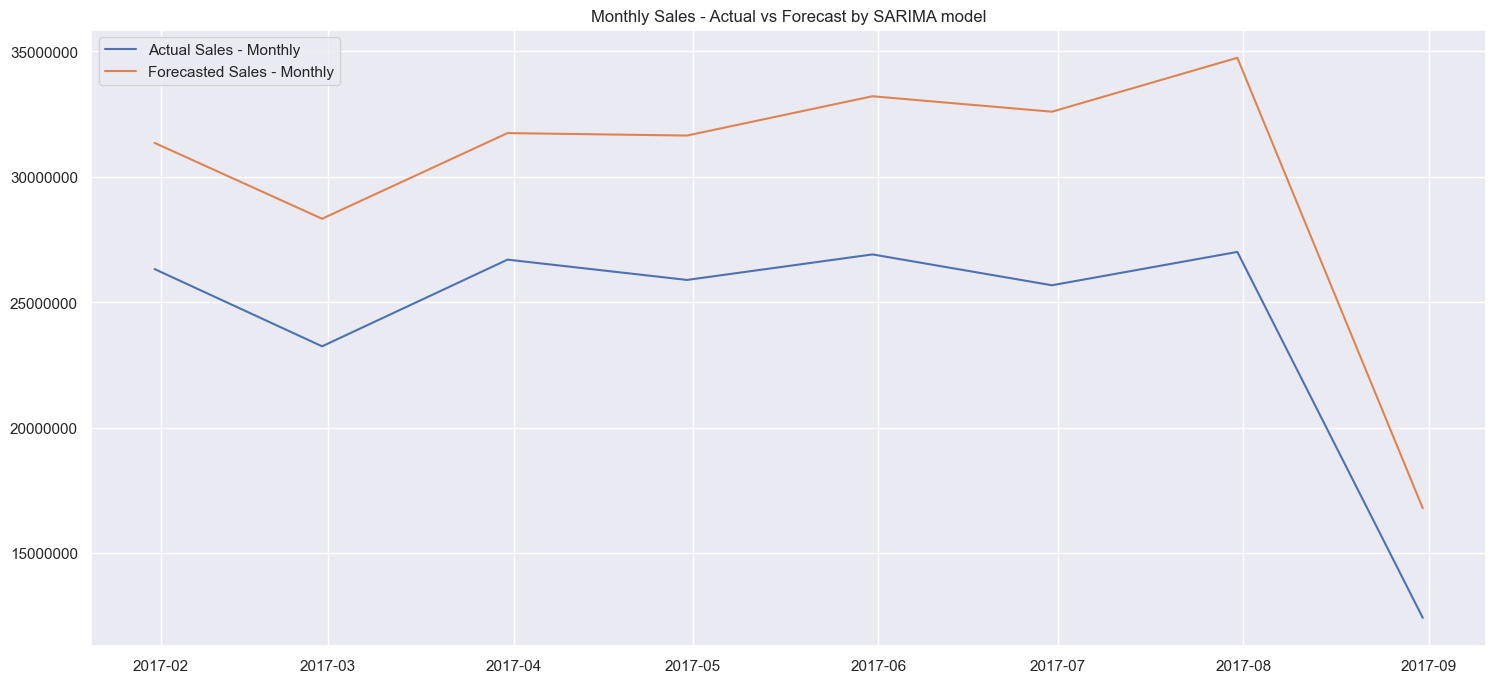

In [57]:
# Resample to monthly frequency, aggregating with sum
monthly_sales_sarima = sarima_forecasted_values_df.resample('M').sum()

# Plot the monthly actual sales and predicted values from the SARIMA model
plt.plot(monthly_sales_sarima['sales_actual'], label='Actual Sales - Monthly')
plt.plot(monthly_sales_sarima['sales_pred'], label='Forecasted Sales - Monthly')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.title('Monthly Sales - Actual vs Forecast by SARIMA model')
plt.show()

Observation: At monthly level, the forcasted sales by ARIMA look pretty close to the actual sales trend on the test data, but on the higher end.

In [58]:
# Save the SARIMA forcast values for the period from 2017-01-01 to 2017-08-15 to an Excel file
sarima_forecasted_values_df.to_excel(r'../outputs/sarima_sales_forecast.xlsx')

In [59]:
# Compute RMSE of the SARIMA model
sarima_rmse = rmse(sarima_forecasted_values_df['sales_actual'], sarima_forecasted_values_df['sales_pred'])
print(f'The RMSE of the SARIMA model forecast is: {sarima_rmse}')

The RMSE of the SARIMA model forecast is: 270911.0634033239


##### 2. Facebook Prophet Model

Same as the SARIMA model above, we'll compare the actual sales and forecasted sales on the 'test' dataset. 

The Prophet model will run only on the sales time series (the actual 'sales' column, not the 'sales_diff_weekly' used in SARIMA). We don't consider other features for simplicity.

In [60]:
# Copy the train data set to a variable named 'train_prophet' to use in this model
train_prophet = train.copy().drop(columns='sales_diff_weekly')

# Reset the index, which moves the date index to a column
train_prophet.reset_index(inplace=True)

# Rename the columns
train_prophet = train_prophet.rename(columns={'date': 'ds', 'sales': 'y'})

train_prophet

,ds,y
0,2013-01-15,299129.54995
1,2013-01-16,318347.91395
2,2013-01-17,267498.51598
3,2013-01-18,296130.85003
4,2013-01-19,432459.85202
...,...,...
1438,2016-12-27,842475.49012
1439,2016-12-28,951533.71385
1440,2016-12-29,894108.23683
1441,2016-12-30,1163643.03799


In [61]:
prophet_model = Prophet()
prophet_model.fit(train_prophet)

20:37:39 - cmdstanpy - INFO - Chain [1] start processing
20:37:39 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
# Select a filepath to save the Prophet model
prophet_model_filepath = r'../models/prophet_model.joblib'

# Use joblib.dump to save the Prophet model object to a file
joblib.dump(prophet_model, prophet_model_filepath)

['../models/prophet_model.joblib']

In [63]:
# Copy the test data set to a variable named 'test_prophet' to use in this model
test_prophet = test.copy().drop(columns='sales_diff_weekly')

# Reset the index, which moves the date index to a column
test_prophet.reset_index(inplace=True)

# Rename the columns
test_prophet = test_prophet.rename(columns={'date': 'ds', 'sales': 'y'})
test_prophet

,ds,y
0,2017-01-01,12082.50100
1,2017-01-02,1402306.37083
2,2017-01-03,1104377.07982
3,2017-01-04,990093.46374
4,2017-01-05,777620.95407
...,...,...
222,2017-08-11,826373.72202
223,2017-08-12,792630.53508
224,2017-08-13,865639.67747
225,2017-08-14,760922.40608


In [64]:
# Create a new DataFrame for predictions with the correct 'ds' column name.
forecast_dates = pd.DataFrame({'ds': test_prophet['ds']})

In [65]:
# Load the Prophet model object from filepath
prophet_model_object = joblib.load(prophet_model_filepath)

In [66]:
# Make predictions for the forecast dates of the 'test_prophet' dataset
prophet_forecasted_values = prophet_model_object.predict(forecast_dates)
prophet_forecasted_values

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,797507.28404,972468.22609,1244988.49871,797507.28404,797507.28404,311831.66144,311831.66144,311831.66144,185689.88431,185689.88431,185689.88431,126141.77713,126141.77713,126141.77713,0.00000,0.00000,0.00000,1109338.94548
1,2017-01-02,797527.11073,753987.73348,1016758.98174,797527.11073,797527.11073,92840.08679,92840.08679,92840.08679,-20323.98418,-20323.98418,-20323.98418,113164.07098,113164.07098,113164.07098,0.00000,0.00000,0.00000,890367.19752
2,2017-01-03,797546.93742,706152.99082,970704.45434,797546.93742,797546.93742,35748.02504,35748.02504,35748.02504,-64316.12840,-64316.12840,-64316.12840,100064.15344,100064.15344,100064.15344,0.00000,0.00000,0.00000,833294.96246
3,2017-01-04,797566.76411,711908.16630,969137.44371,797566.76411,797566.76411,42179.75098,42179.75098,42179.75098,-44856.87940,-44856.87940,-44856.87940,87036.63038,87036.63038,87036.63038,0.00000,0.00000,0.00000,839746.51509
4,2017-01-05,797586.59080,616214.37304,873974.26134,797586.59080,797586.59080,-50501.79103,-50501.79103,-50501.79103,-124769.00701,-124769.00701,-124769.00701,74267.21597,74267.21597,74267.21597,0.00000,0.00000,0.00000,747084.79977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,2017-08-11,801908.80936,537384.47863,809124.90106,769598.20664,834425.42923,-126740.98449,-126740.98449,-126740.98449,-58209.51052,-58209.51052,-58209.51052,-68531.47397,-68531.47397,-68531.47397,0.00000,0.00000,0.00000,675167.82488
223,2017-08-12,801928.63605,726367.67196,993427.34655,769430.46742,834771.05417,57847.37424,57847.37424,57847.37424,126785.62520,126785.62520,126785.62520,-68938.25096,-68938.25096,-68938.25096,0.00000,0.00000,0.00000,859776.01030
224,2017-08-13,801948.46274,779610.77818,1044837.51839,769188.06420,835116.67912,117025.06392,117025.06392,117025.06392,185689.88431,185689.88431,185689.88431,-68664.82039,-68664.82039,-68664.82039,0.00000,0.00000,0.00000,918973.52666
225,2017-08-14,801968.28944,586271.46552,854378.61167,768892.36582,835462.30406,-88038.12147,-88038.12147,-88038.12147,-20323.98418,-20323.98418,-20323.98418,-67714.13728,-67714.13728,-67714.13728,0.00000,0.00000,0.00000,713930.16797


In [67]:
# Display the last few rows of the forecasted values including the date (ds),
# The predicted value (yhat), and the lower and upper bounds of the prediction intervals.
prophet_forecasted_values[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
222,2017-08-11,675167.82488,537384.47863,809124.90106
223,2017-08-12,859776.01030,726367.67196,993427.34655
224,2017-08-13,918973.52666,779610.77818,1044837.51839
225,2017-08-14,713930.16797,586271.46552,854378.61167
226,2017-08-15,671569.90435,537780.59818,813020.54301


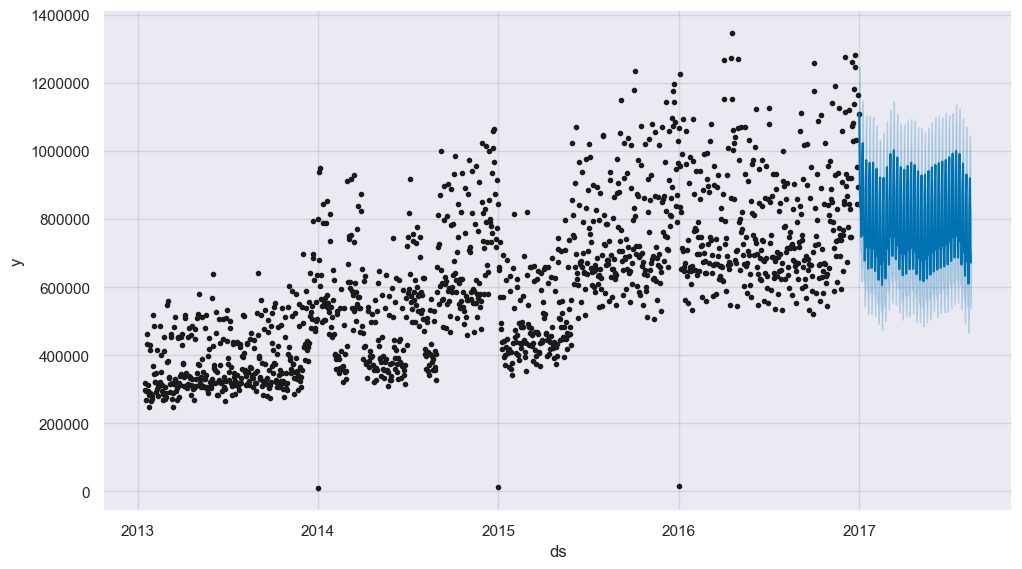

In [68]:
# Plot the forecasted values using Prophet's built-in plot function
prophet_model.plot(prophet_forecasted_values)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

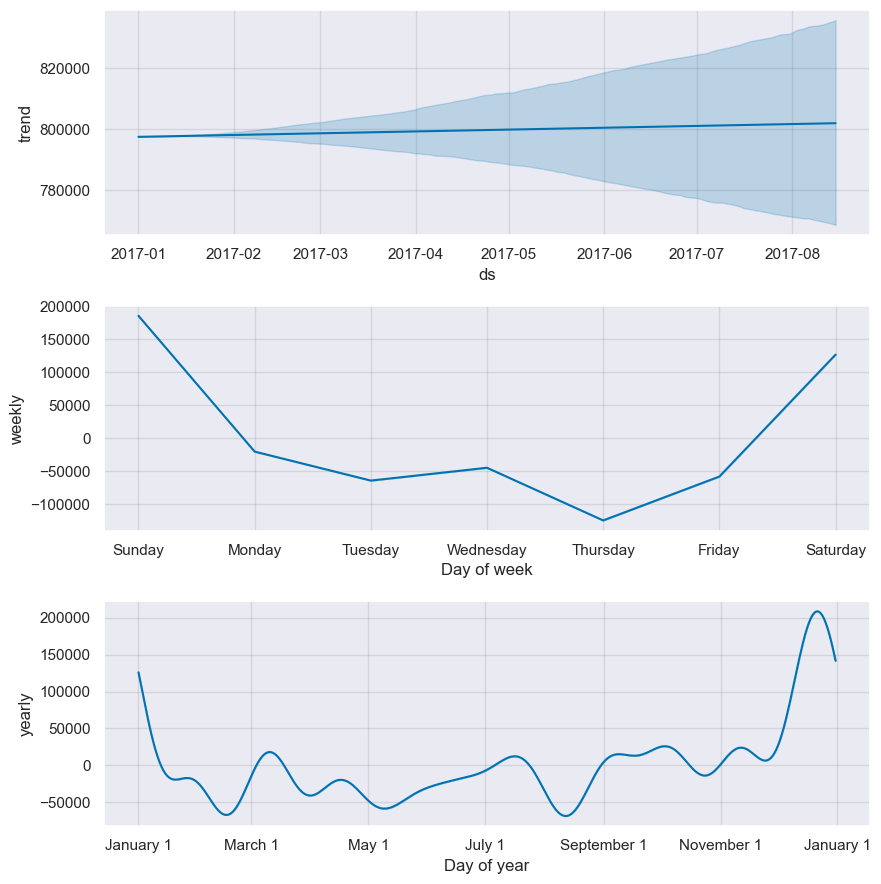

In [69]:
# Plot the forecast components using Prophet's built-in function plot_components
# This generate separate plots for each component of the forecast: trend, holidays, weekly seasonality, etc.
prophet_model.plot_components(prophet_forecasted_values)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [70]:
# Create a copy of 'prophet_forecasted_values' as 'prophet_forecasted_values_df' to output result
prophet_forecasted_values_df = prophet_forecasted_values.copy()

# Drop all columns except for 'ds' and 'yhat'
prophet_forecasted_values_df = prophet_forecasted_values_df[['ds', 'yhat']]

# Rename 'ds' to 'date' and 'yhat' to 'sales_pred'
prophet_forecasted_values_df.rename(columns={'ds': 'date', 'yhat': 'sales_pred'}, inplace=True)

# Get the actual sales from 'test_prophet'
prophet_forecasted_values_df['sales_actual'] = test_prophet['y']

# Make 'date' the index of the DataFrame
prophet_forecasted_values_df.set_index('date', inplace=True)

# Display the updated DataFrame
prophet_forecasted_values_df

,sales_pred,sales_actual
date,,
2017-01-01,1109338.94548,12082.50100
2017-01-02,890367.19752,1402306.37083
2017-01-03,833294.96246,1104377.07982
2017-01-04,839746.51509,990093.46374
2017-01-05,747084.79977,777620.95407
...,...,...
2017-08-11,675167.82488,826373.72202
2017-08-12,859776.01030,792630.53508
2017-08-13,918973.52666,865639.67747


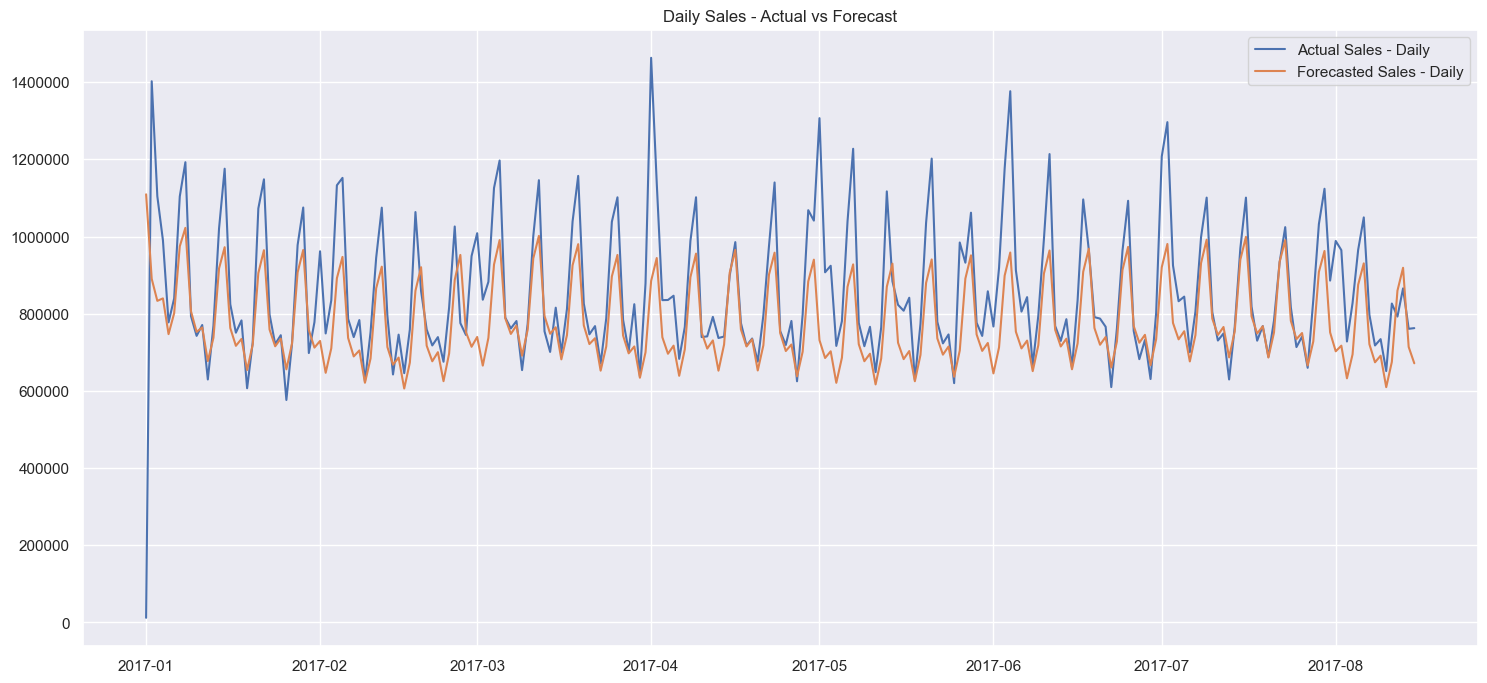

In [71]:
# Plot the daily actual sales and predicted values from the Prophet model
plt.plot(prophet_forecasted_values_df['sales_actual'], label='Actual Sales - Daily')
plt.plot(prophet_forecasted_values_df['sales_pred'], label='Forecasted Sales - Daily')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.title('Daily Sales - Actual vs Forecast')
plt.show()

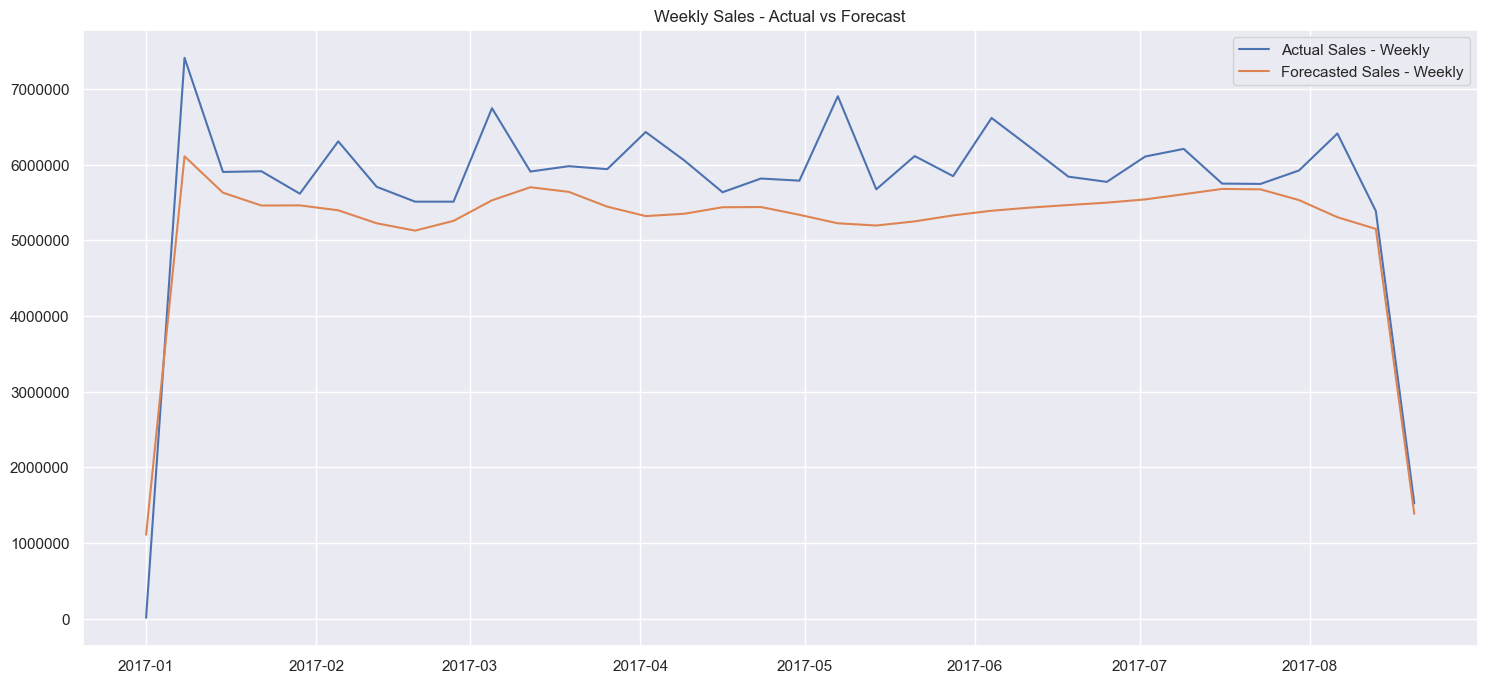

In [72]:
# Resample to weekly frequency, aggregating with sum
weekly_sales_prophet = prophet_forecasted_values_df.resample('W').sum()

# Plot the weekly actual sales and predicted values from the Prophet model
plt.plot(weekly_sales_prophet['sales_actual'], label='Actual Sales - Weekly')
plt.plot(weekly_sales_prophet['sales_pred'], label='Forecasted Sales - Weekly')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.title('Weekly Sales - Actual vs Forecast')
plt.show()

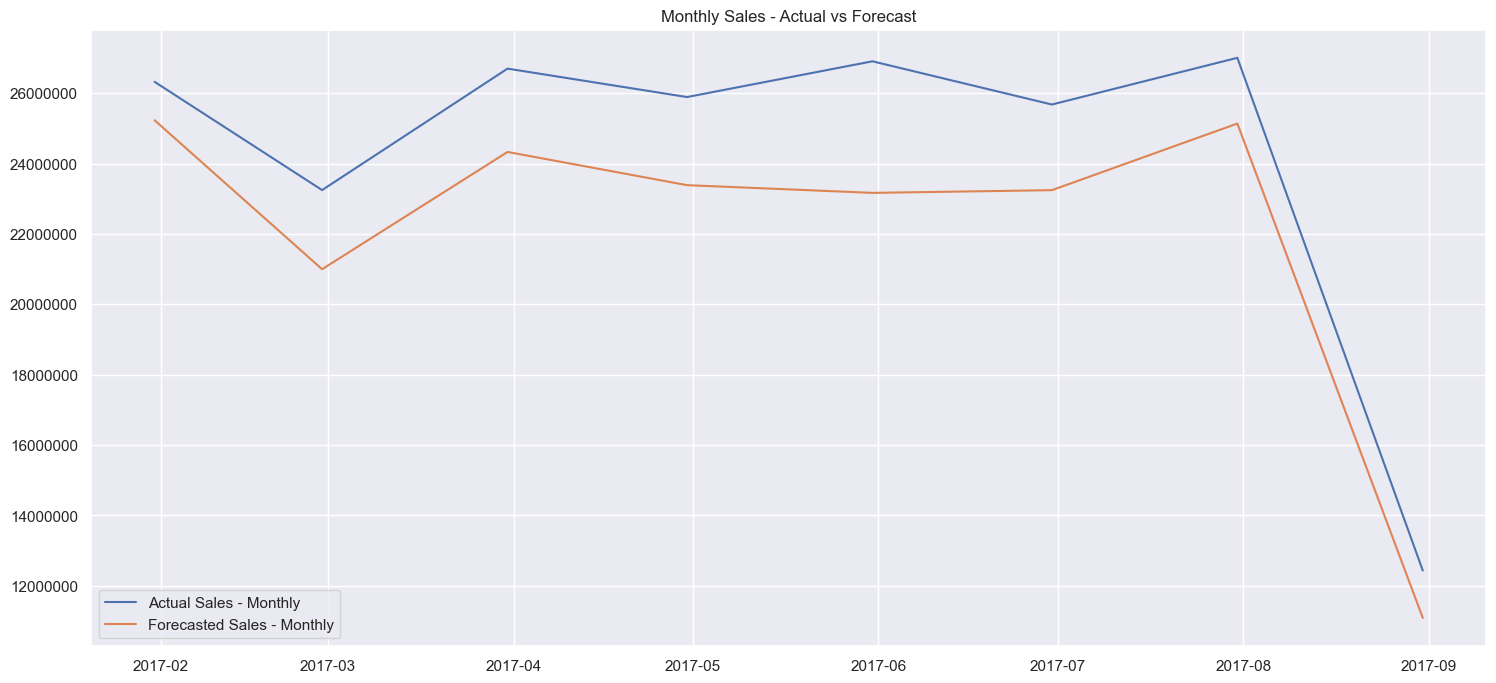

In [73]:
# Resample to monthly frequency, aggregating with sum
monthly_sales_prophet = prophet_forecasted_values_df.resample('M').sum()

# Plot the monthly actual sales and predicted values from the Prophet model
plt.plot(monthly_sales_prophet['sales_actual'], label='Actual Sales - Monthly')
plt.plot(monthly_sales_prophet['sales_pred'], label='Forecasted Sales - Monthly')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.title('Monthly Sales - Actual vs Forecast')
plt.show()

Observation: The forcasted sales by Facebook Prophet look very close to the actual sales trend on the test data at all levels of the time periods (weekly, daily and monthly), but on the lower end. Compared to the SARIMA model, the Facebook Prophet model visually makes more accurate sales forecasts that resembles the trend of the actual sales data.

In [74]:
# Save the Prophet forcast values for the period from 2017-01-01 to 2017-08-15 to an Excel file
prophet_forecasted_values_df.to_excel(r'../outputs/prophet_sales_forecast.xlsx')

In [75]:
# Compute RMSE of the SARIMA model
prophet_rmse = rmse(prophet_forecasted_values_df['sales_actual'], prophet_forecasted_values_df['sales_pred'])
print(f'The RMSE of the Prophet model forecast is: {prophet_rmse}')

The RMSE of the Prophet model forecast is: 150513.79220969952


##### 3. Compare the RMSE of both Models

In [76]:
# Create a dictionary with the model names as keys and the RMSE values as values
rmse_values = {
    'Model': ['SARIMA', 'Prophet'],
    'RMSE': [sarima_rmse, prophet_rmse]
}

# Create a 'rmse_table' DataFrame using the dictionary
rmse_table = pd.DataFrame(rmse_values)

# Display the 'rmse_table'
print(rmse_table)

     Model         RMSE
0   SARIMA 270911.06340
1  Prophet 150513.79221


Based on the RMSE (Root Mean Square Error) values provided for the SARIMA and Prophet models:

* In terms of Model Performance: The Prophet model has a lower RMSE value compared to the SARIMA model which indicates the Prophet model is more suitable for this particular time series forecasting task. Generally, a lower RMSE indicates better predictive accuracy, as it reflects a smaller average magnitude of error in the predictions.

* In temrs Error Magnitude: The magnitude of the RMSE values suggests that the predictions are, on average, off by the amount of the RMSE from the actual values. For SARIMA, this deviation is approximately 270,911 units, whereas for Prophet, it is around 150,514 units. The lower deviation in Prophet suggests its forecasts are closer to the actual values.

### Part 4: Conclusion

* Prophet is known to handle seasonality and holiday effects well. Our data have a certain degree of effects from the EDA, thus it explains the better performance of Prophet model than the SARIMA model. Given the results, we might favor using the Prophet model or similar models that capture the data patterns of seasonality of grocery sales well. However, if there is new data with different characteristics, the model's performance should be re-evaluated.

* Business implications: As we mentioned Part 3 of each model, the forecasted sales of SARIMA are mostly higher than the actual sales in our investigated scenarios (totalling sales daily, weekly and monthly). Reversedly, Facebook's Prophet gives a more accurate forecasted sales yet mostly on the lower end compared to actual. Depending on the business strategy of forecasting and performance tracking, we might consider: Using SARIMA's sales forecast results in case of an optimistic business scenario or focusing on setting a high target; whereas using Prophet's sales forecasting for a realistic business scenario or low-target setting.

* Considerations for Improvement: While Prophet is performing better than SARIMA model, there's still a significant error that we might want to reduce. This could involve hyperparameter tuning, incorporating external variables, or trying different transformations of the data. For now, we're just focusing the time series of the total sales per period. 
